In [1]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares
import re
%matplotlib inline

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}
base_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

import sncosmo

Important functions 

In [2]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b

def gauss(x, a, x0, sigma, b):
    return a*exp(-(x-x0)**2/(2*sigma**2))+b


def residuals(p, x, y):
    a, m, s, b = p
    y_fit = gauss(x, a, m, s, b)
    
    err = y - y_fit
    return err

def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index
    
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    max_i = get_max_index(t_by_filter["flux"])
    mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        n = len(x)
        sigma = np.std(y)
        
      
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[1, mean_date, 2, 1, 0], maxfev=50000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)

        #print len(x) - len(popt)
        #print (chi2 / (len(x)-len(popt)))
        if plot==True:
            plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])

            X = np.arange(0,max_date-min_date,1)

            plt.plot(X, mod_gauss(X, *popt), color=colors[data[0]["bandpass"]])
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
    #plt.show()
    return popt, pcov, chi2, dof


This method opens all the extracted Stack light curves

In [3]:
lienObj = glob.glob("/datadec/cppm/jpreyes/mpi_tests/multicolour_set/*.dat")
lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)

With this piece of code, we filter light curves with at least 3 curves in the different bands

In [4]:
s_candidates= []
for lc in lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    if len(indices)>=3:
        s_candidates.append(lc)

This also alow us to select only the candidates with at least N points.

In [5]:
res = None
for s in s_candidates:
    if len(s)>15:
        res = s

Opening the control data: SNLS curves

In [6]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()


Extracting and building the sncosmo tables from the SNLS data

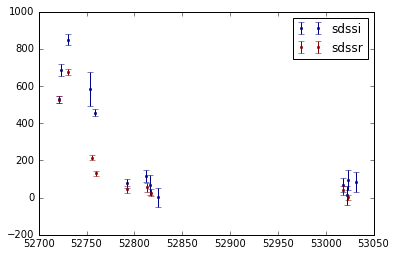

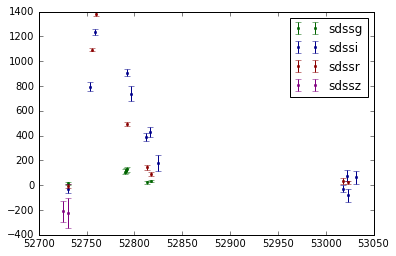

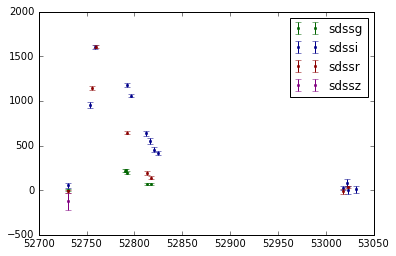

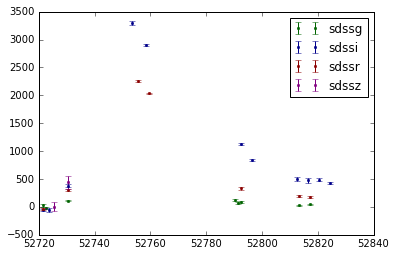

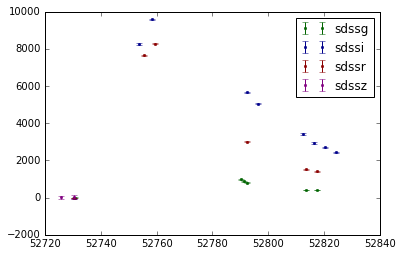

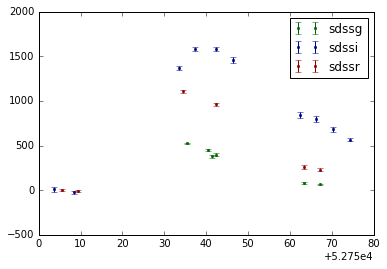

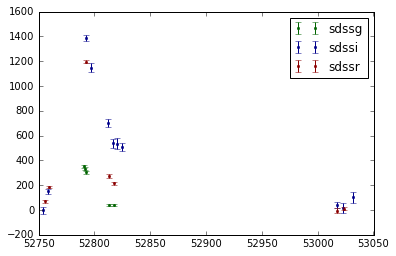

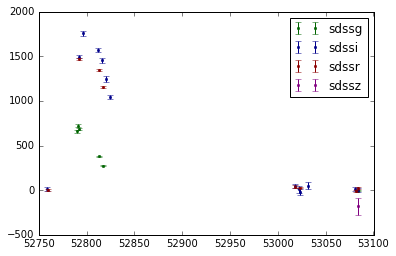

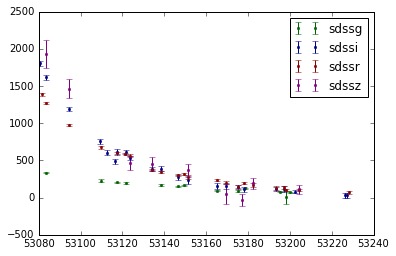

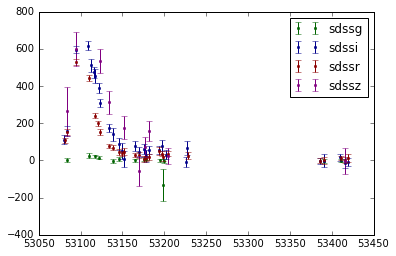

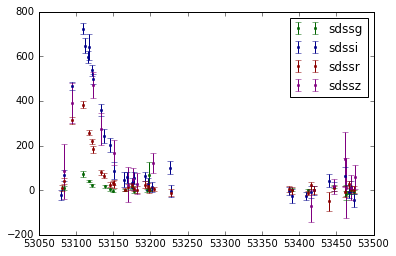

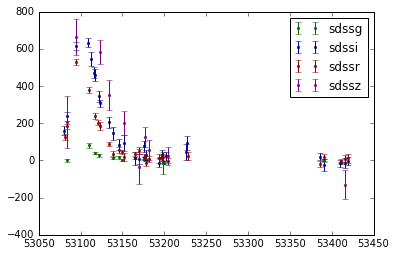

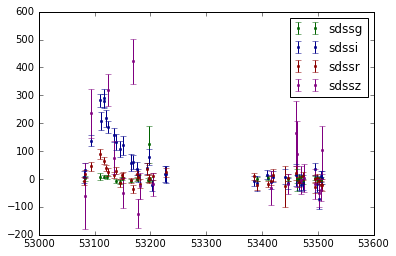

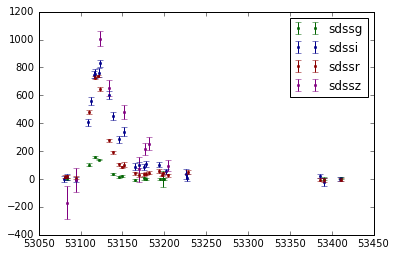

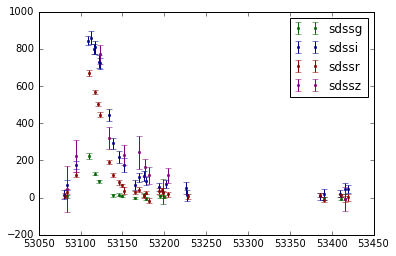

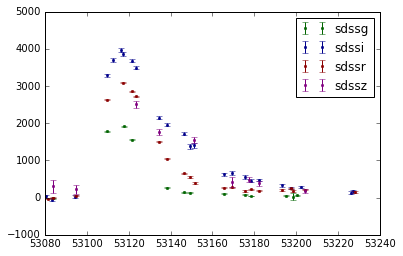

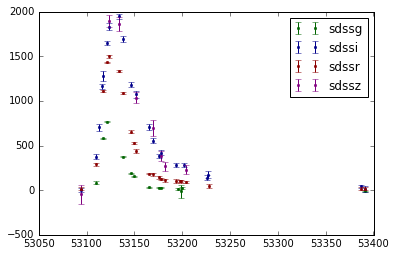

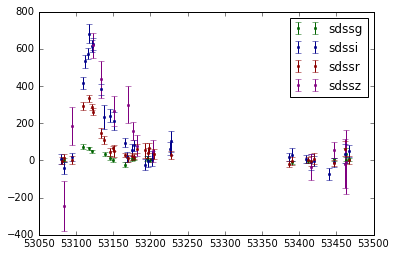

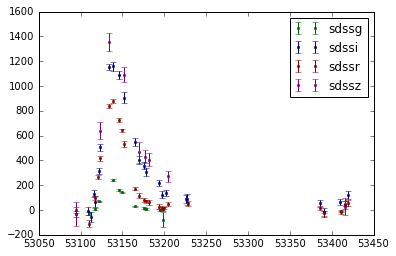

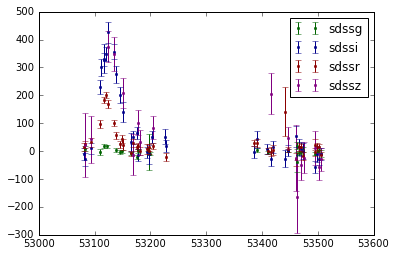

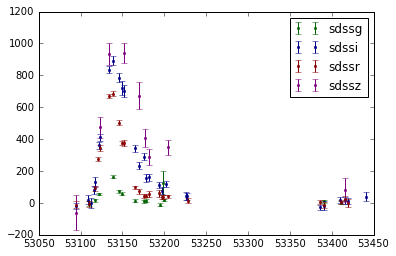

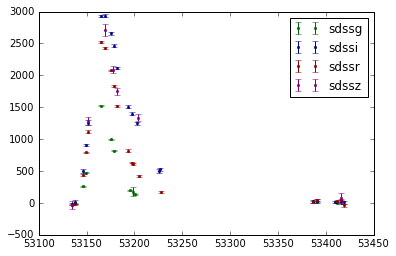

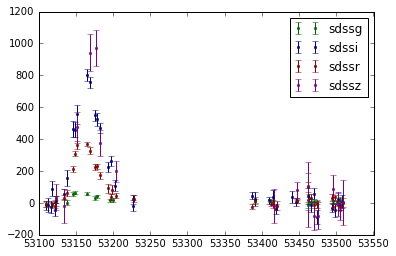

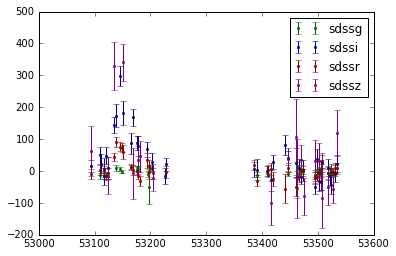

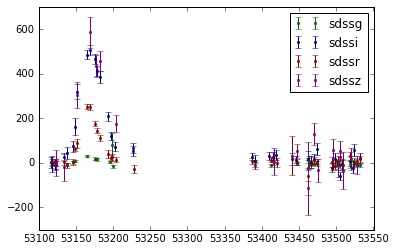

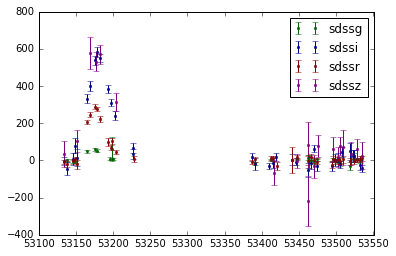

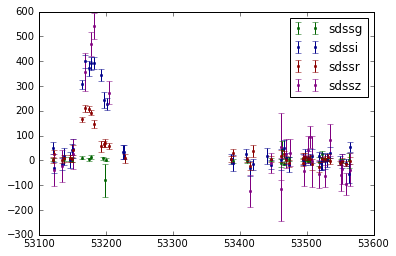

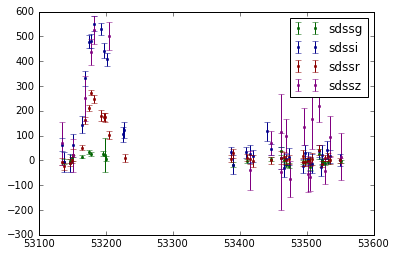

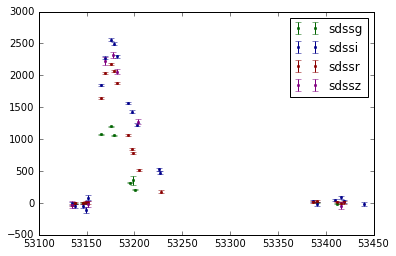

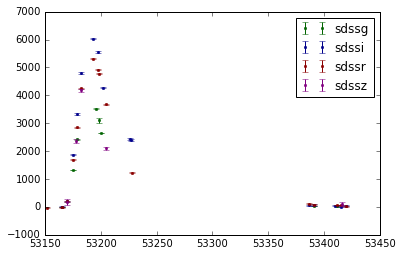

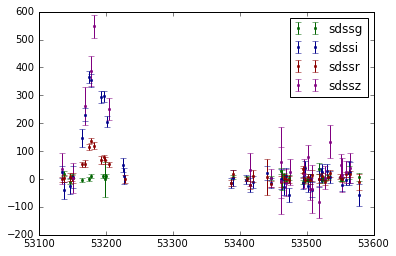

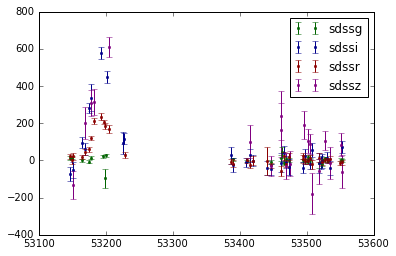

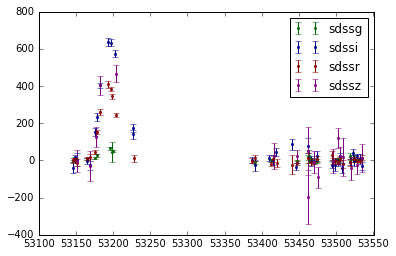

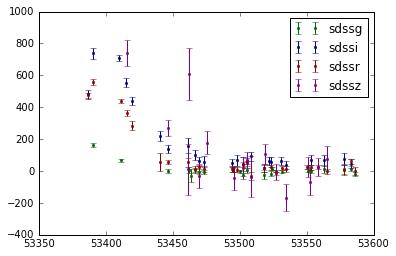

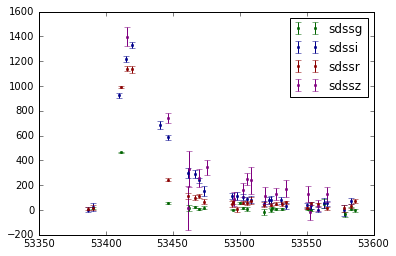

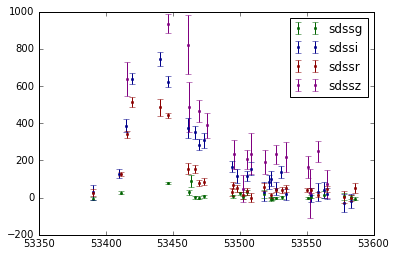

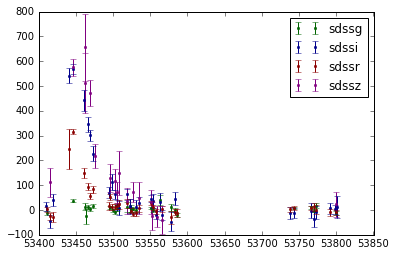

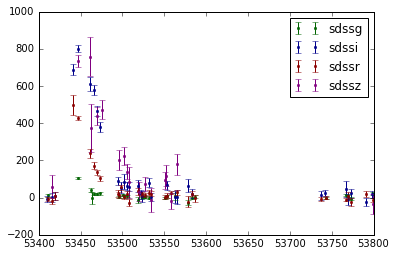

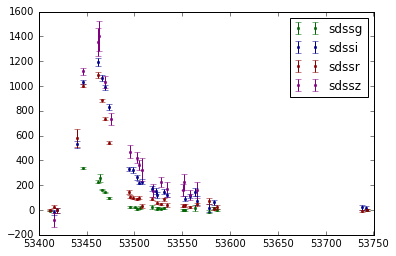

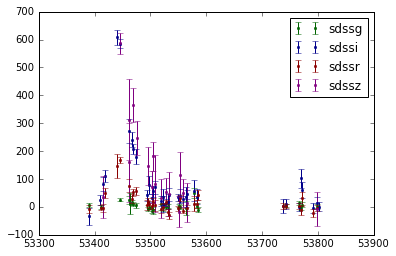

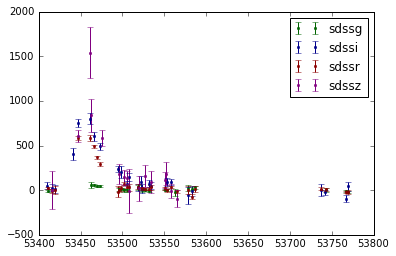

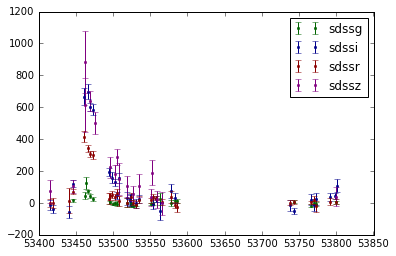

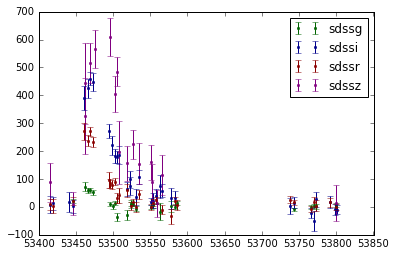

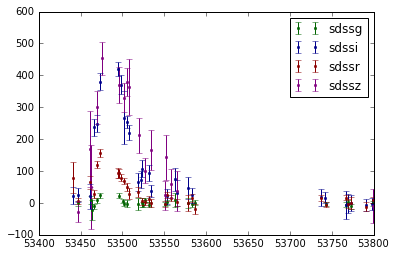

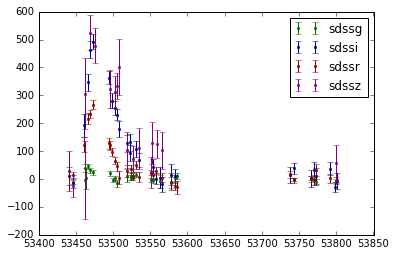

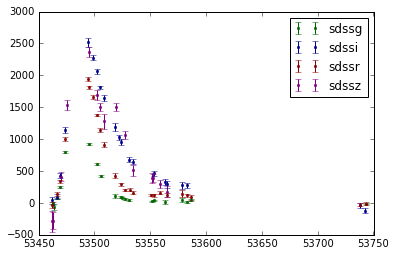

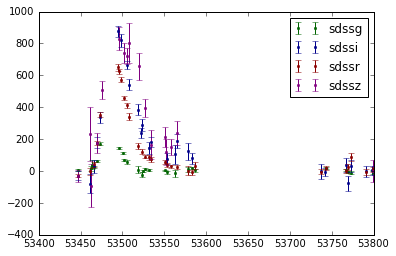

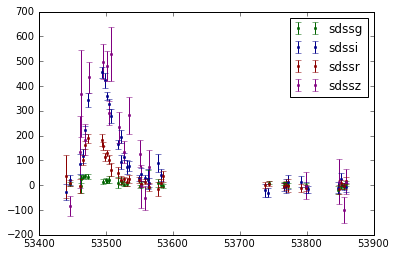

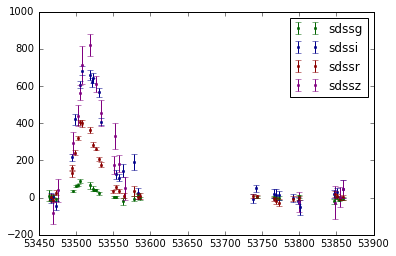

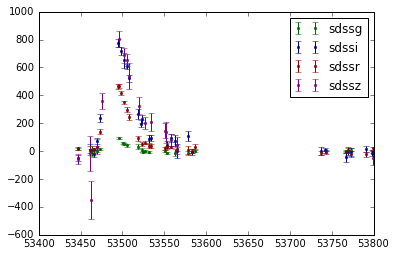

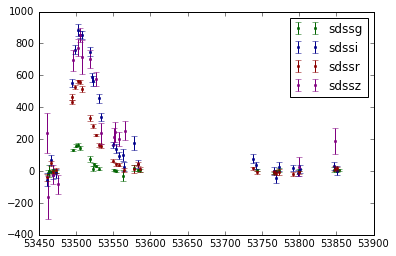

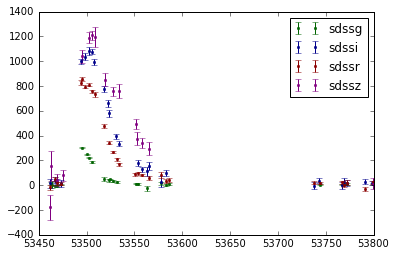

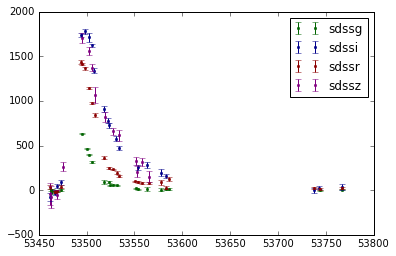

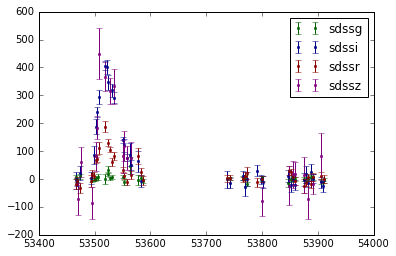

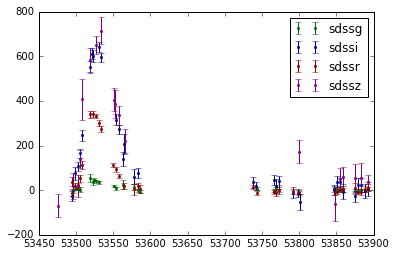

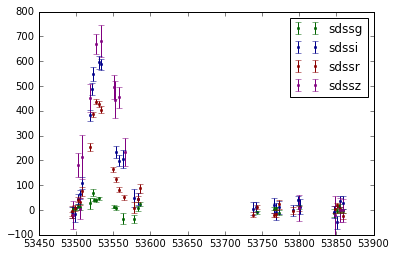

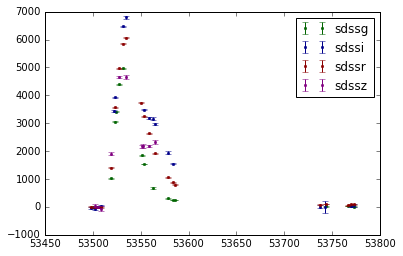

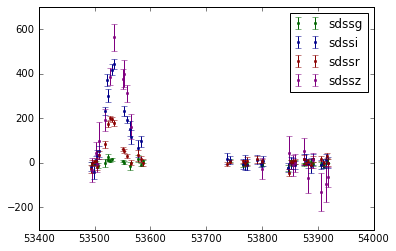

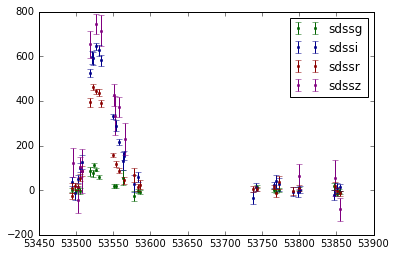

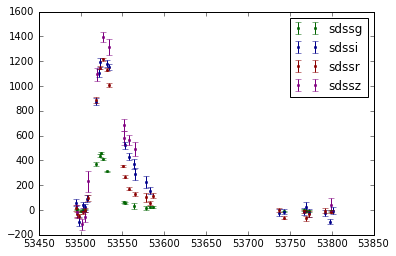

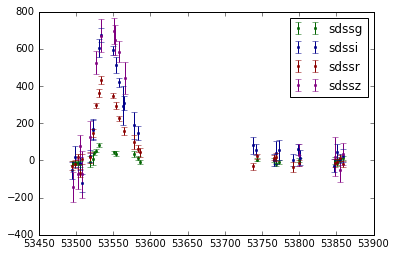

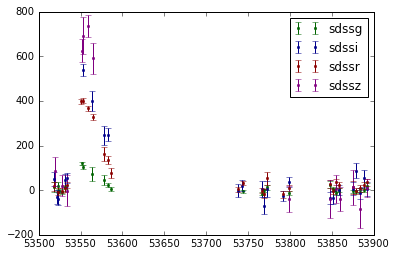

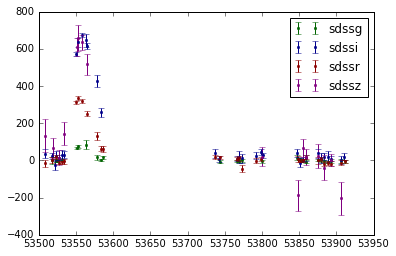

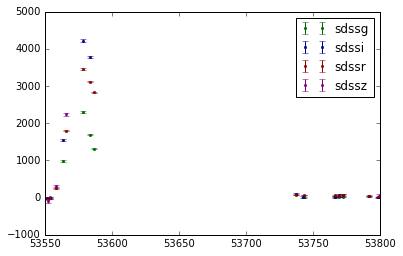

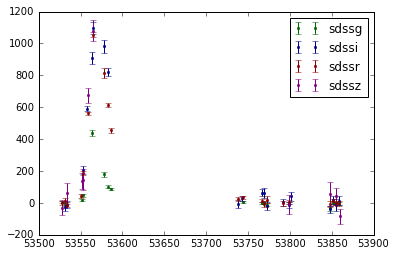

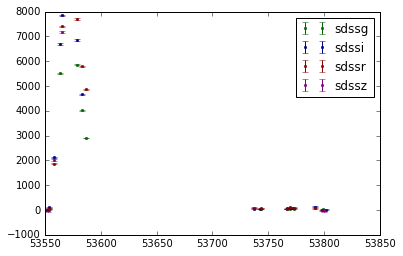

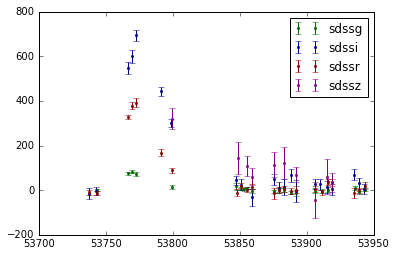

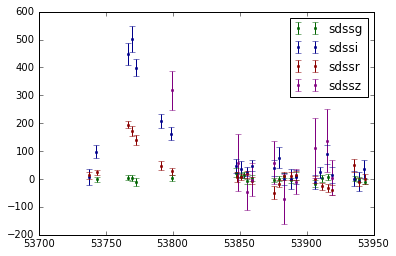

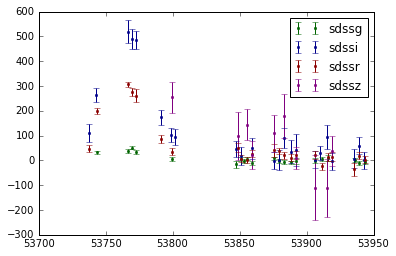

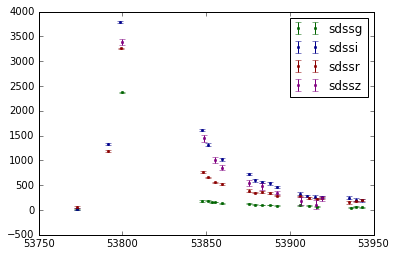

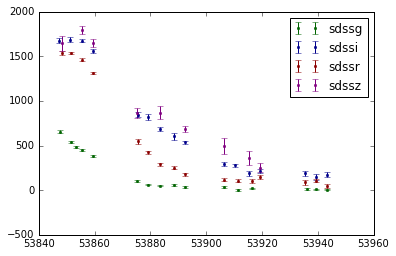

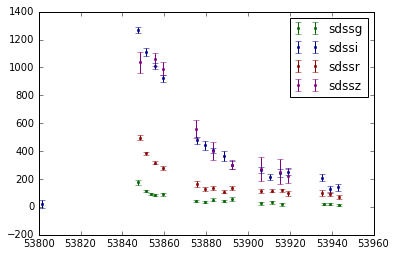

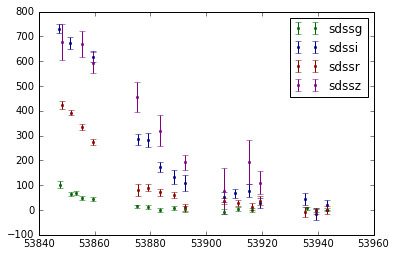

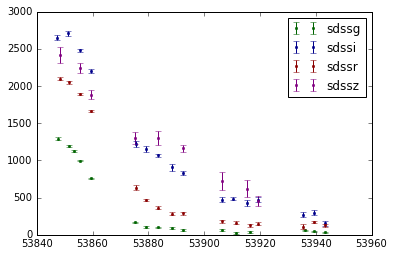

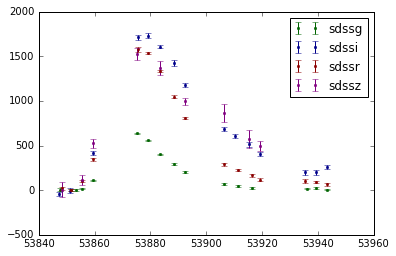

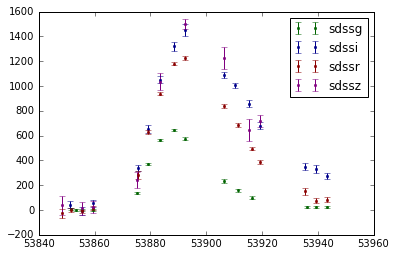

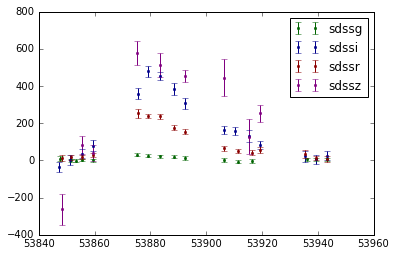

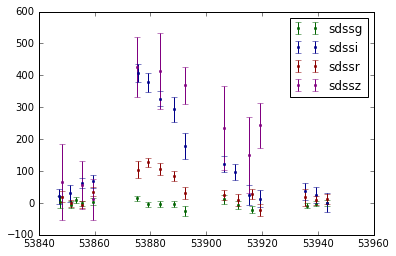

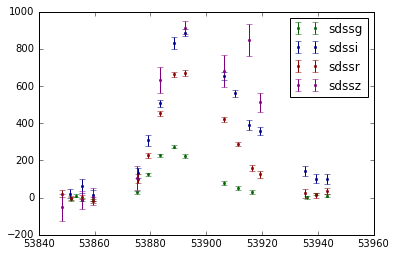

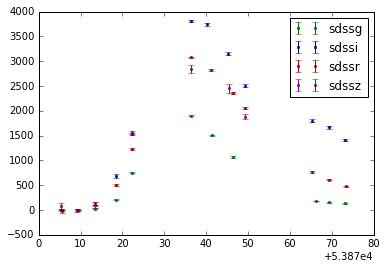

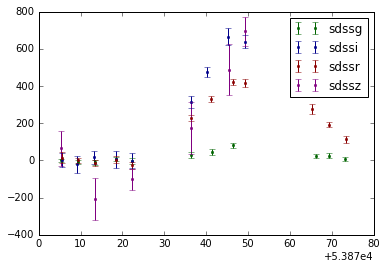

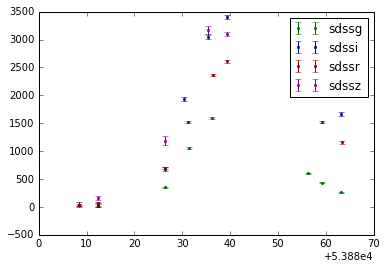

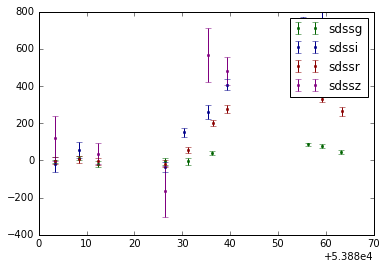

total of sn:83


In [7]:
snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

        snls_lc = DSTools.build_light_curve_from_snls_file(m, c)

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))


Matching the SNLS with Stack. Indexes are the matched curves

In [8]:
matches_sc = match_with_lc(snls_array, s_candidates)

41621
33218
39979
4614
32534
41285
51207
11598
9449
14546
30854
24411
50072
38204
21642
44053
15057
16502
16603
16868
47667
36450
8186
30434
35702
27635
1912
45674
39072
8199
32302
34242
27933
25340
23693
27747
27769
6845
16114
22911
50431
7426
45985
791
25300
35487
19303
39984
13369
23460
6020
50501
26713
33667
13351
15552
36261
36128
32008
3291
42348
39357
25607
13973
5198
16436
47300
12107
24824
29032
23947
39911
26438
9659
17376
21861
76


In [9]:
s = snls_array[10]
data = sncosmo.load_example_data()
model = sncosmo.Model(source='salt2')
res, fitted_model = sncosmo.fit_lc(s, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.3, 0.9)})

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssg(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


We extract the $\chi^2$ using the SALT2 fitting for all the control curves

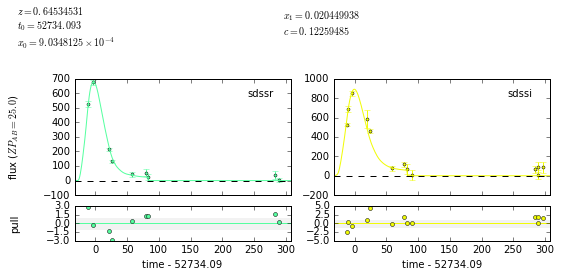

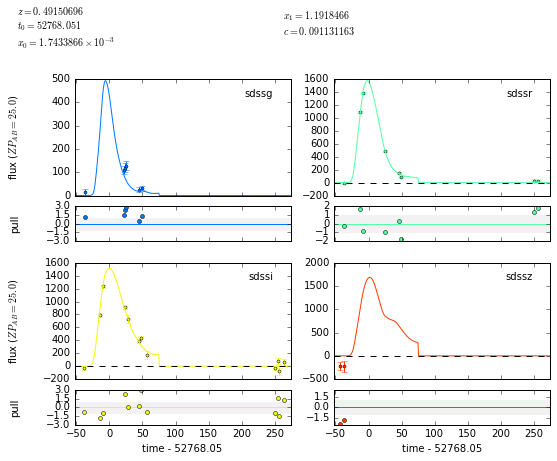

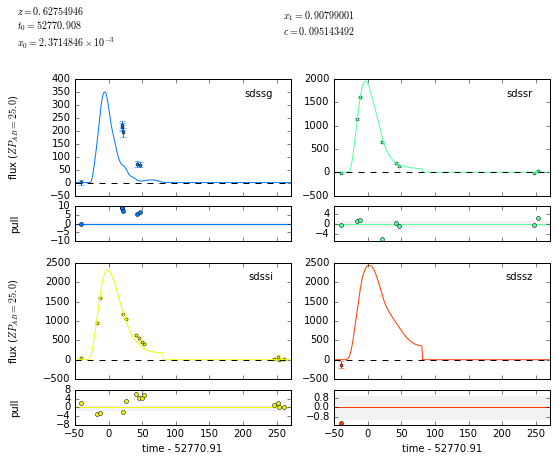

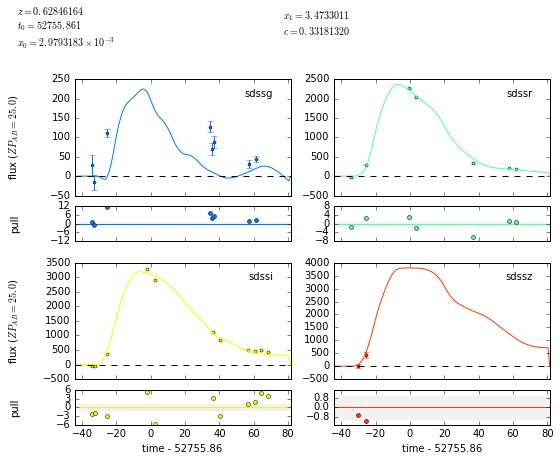

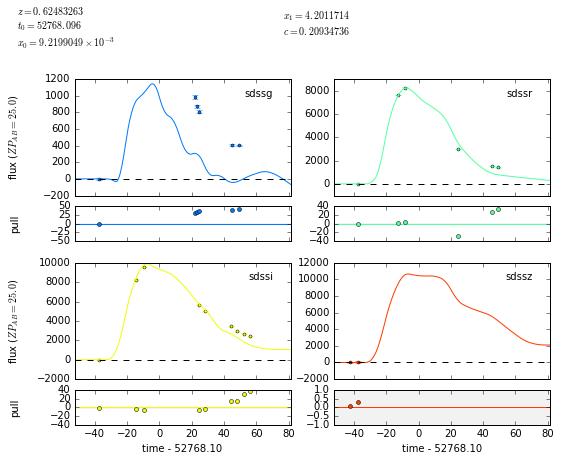

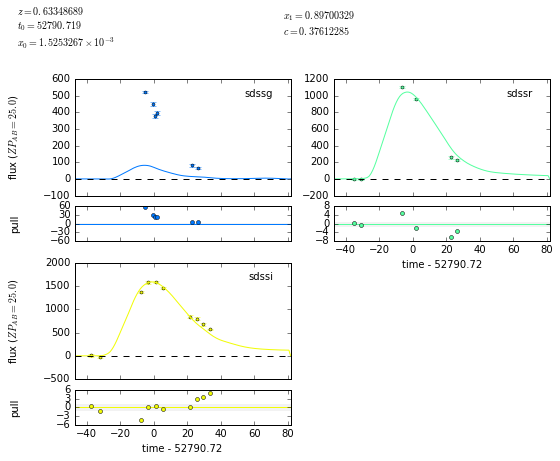

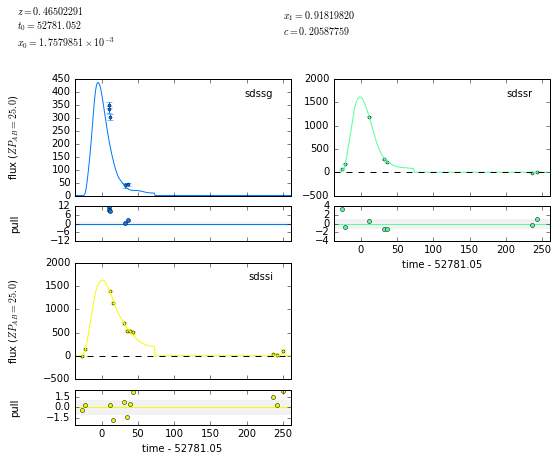

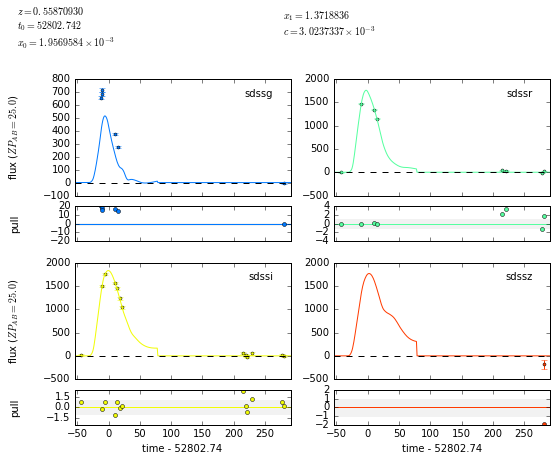

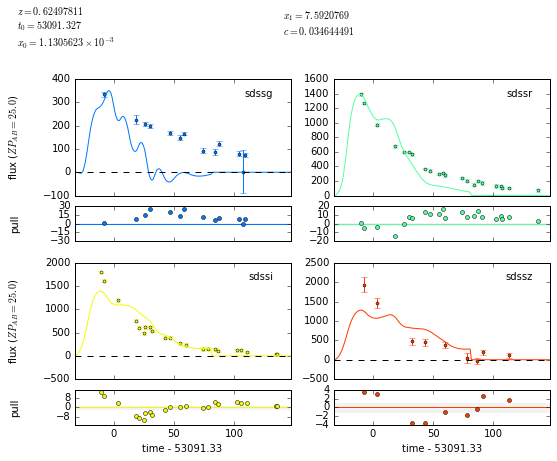

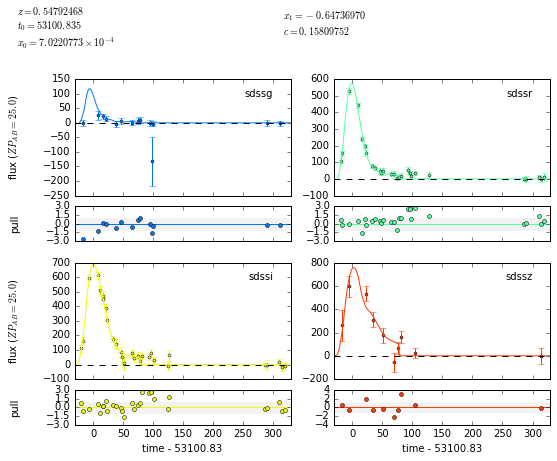

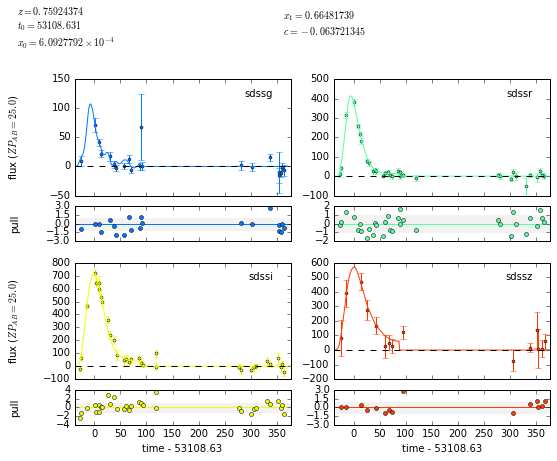

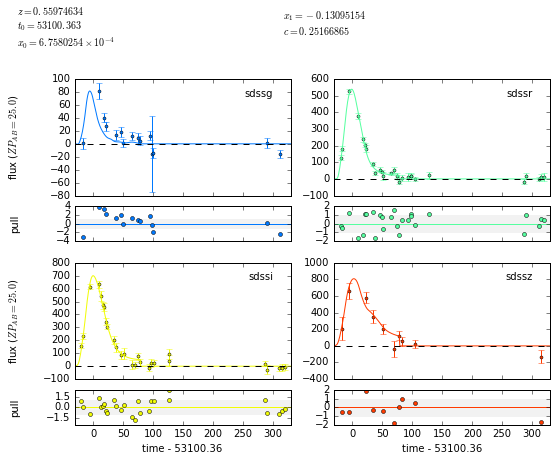

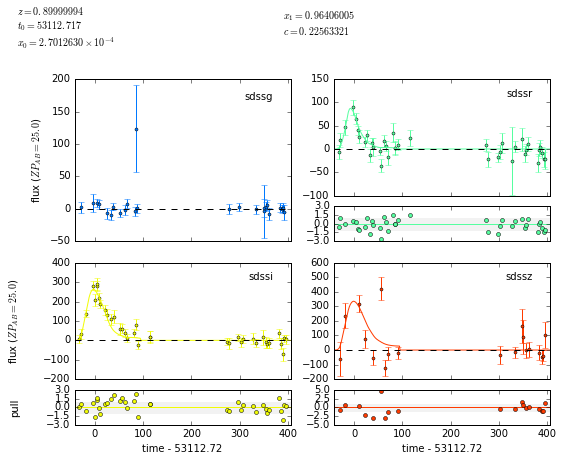

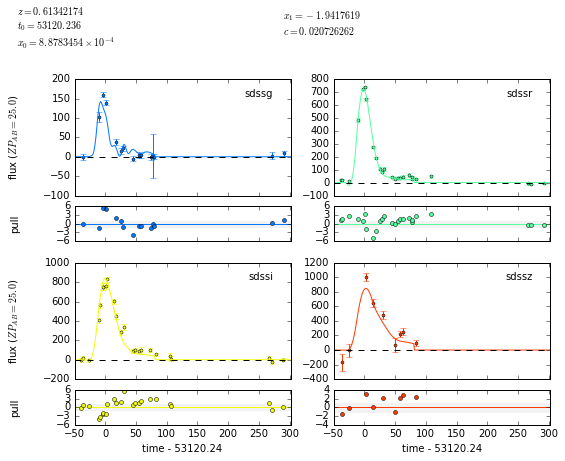

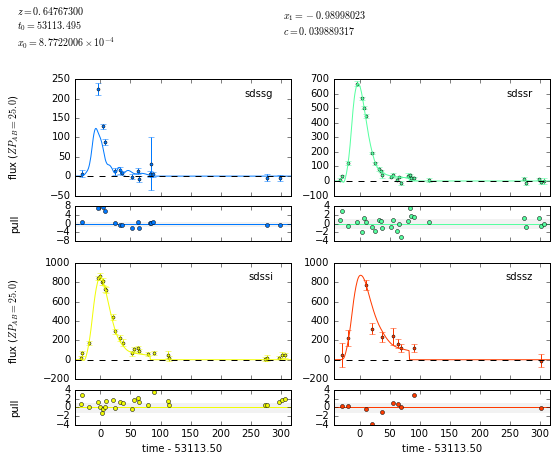

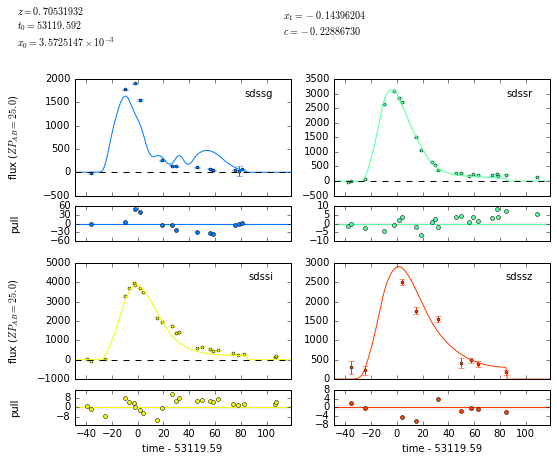

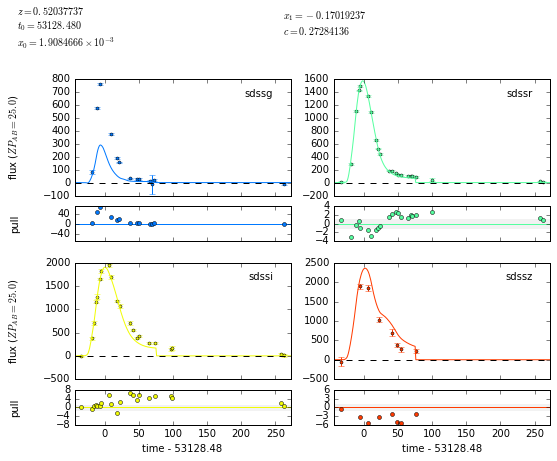

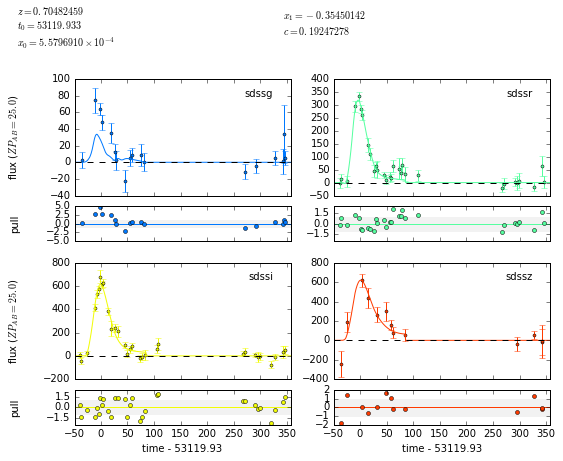

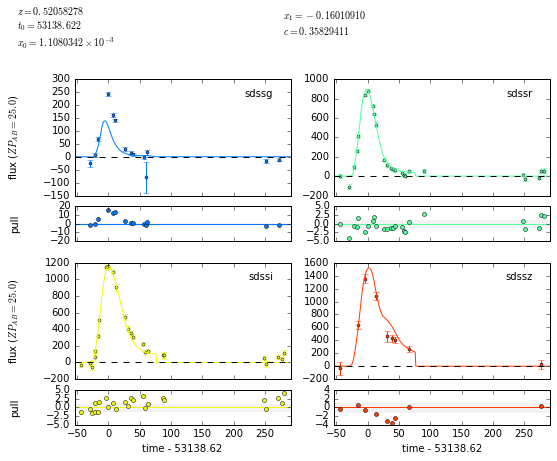

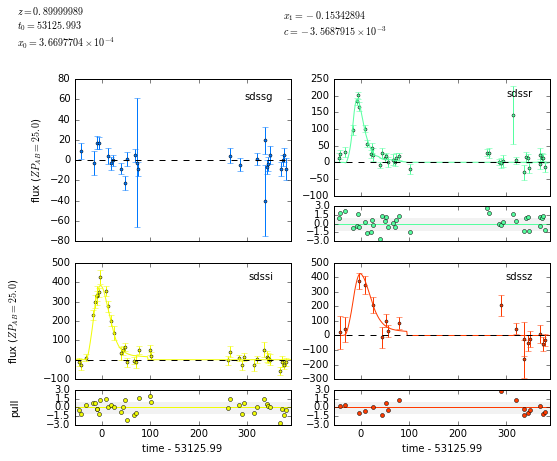

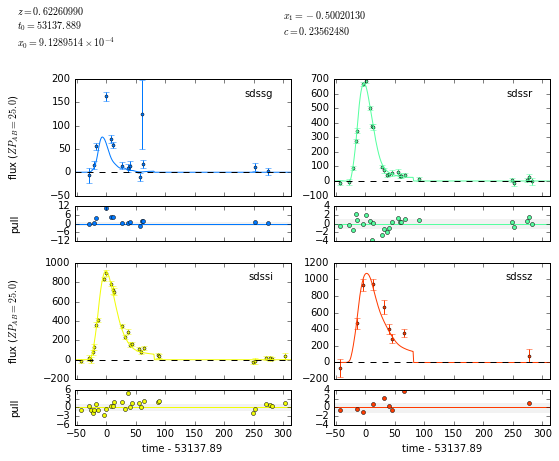

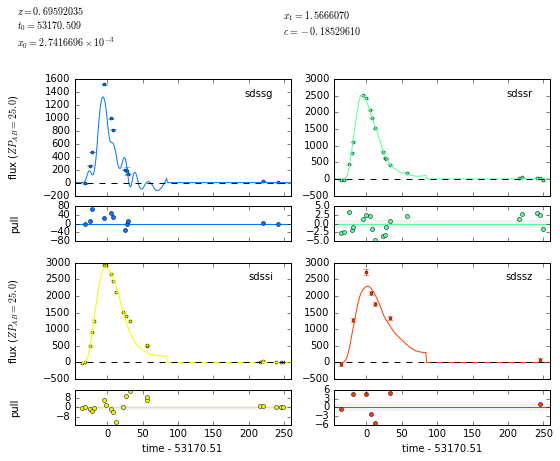

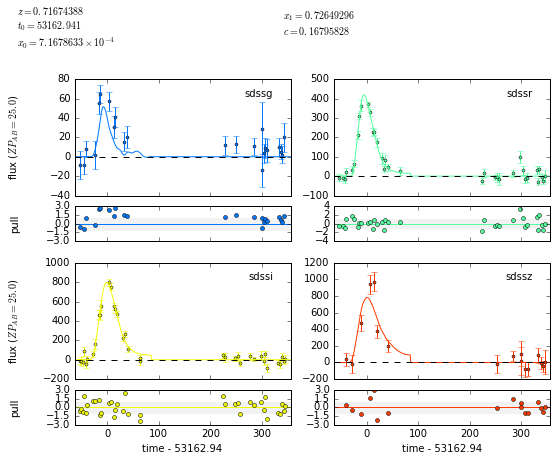

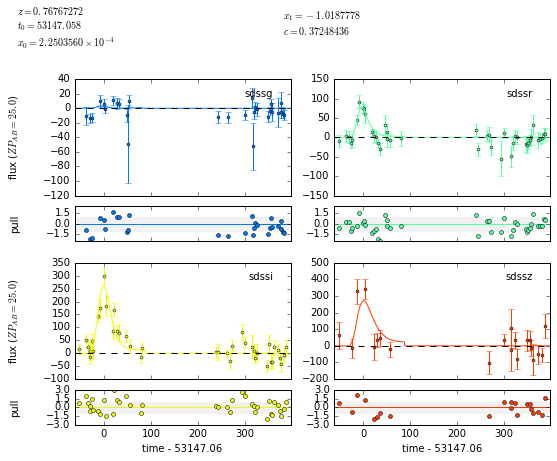

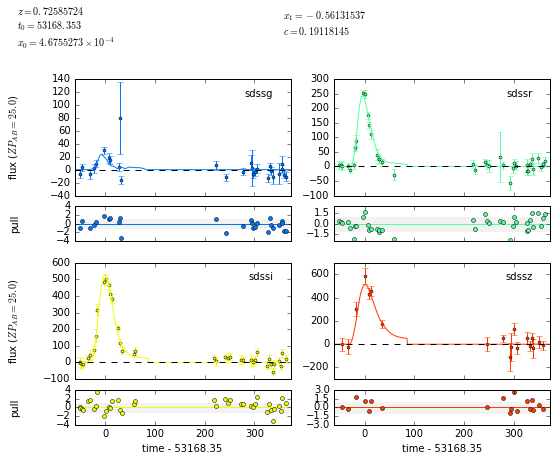

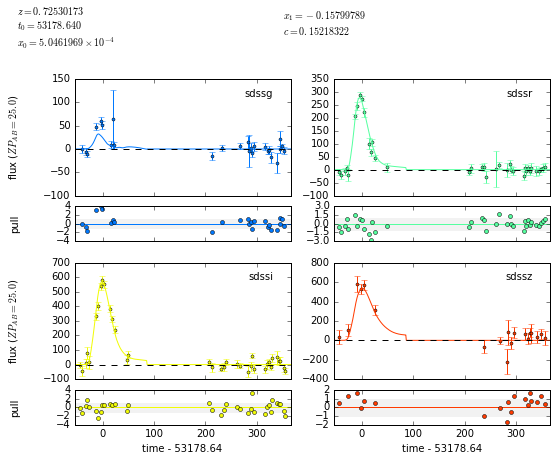

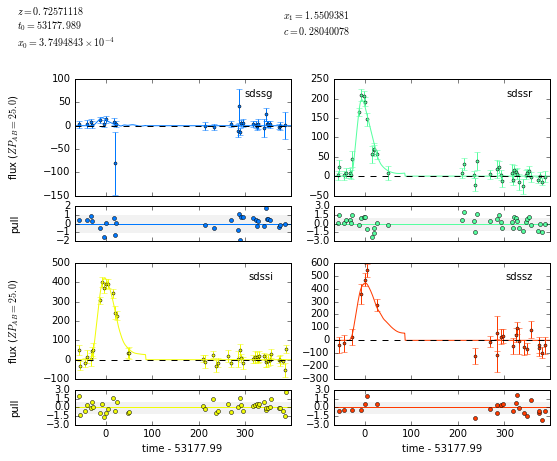

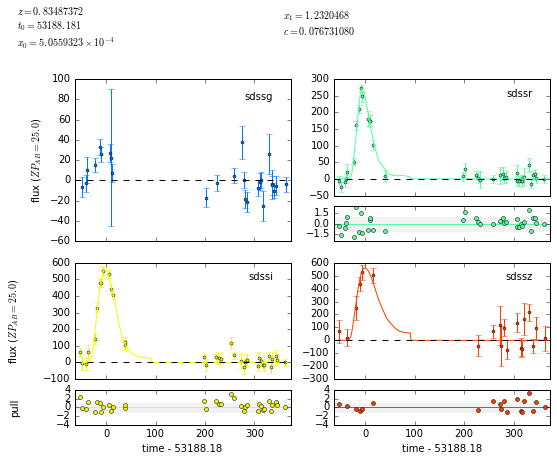

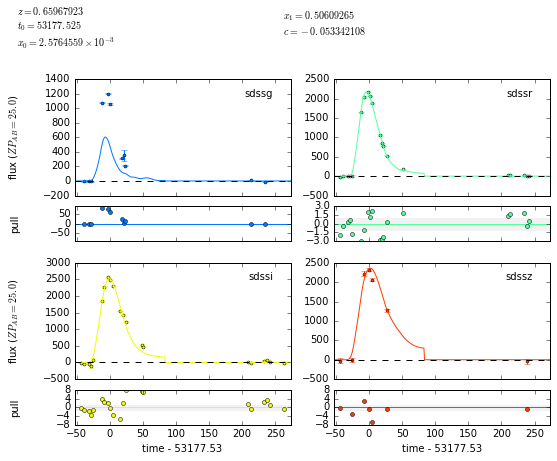

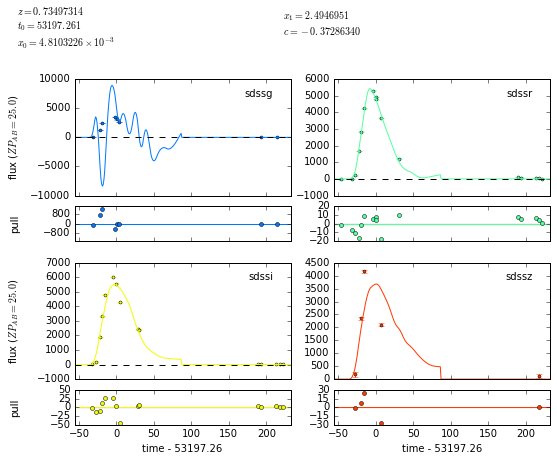

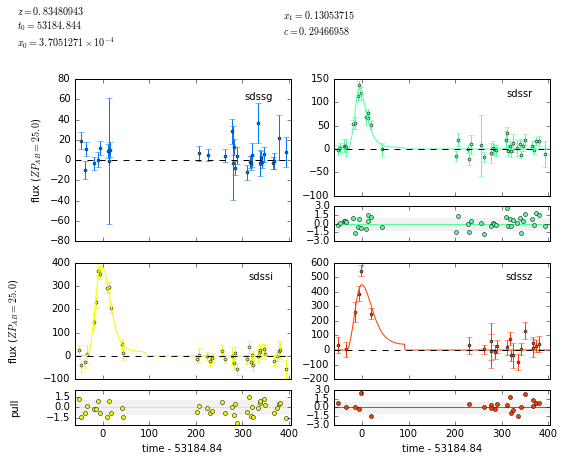

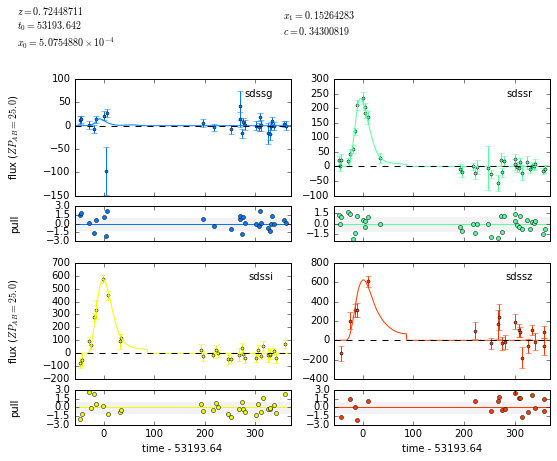

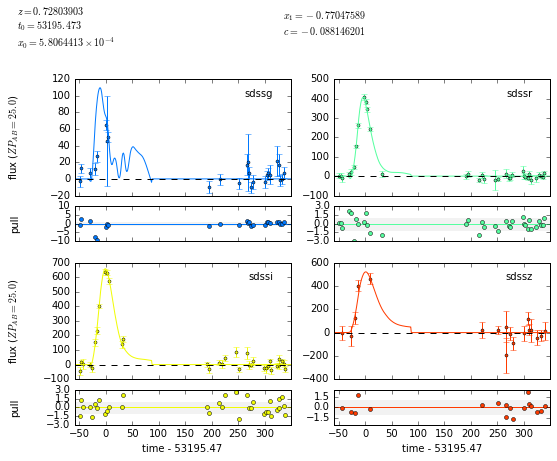

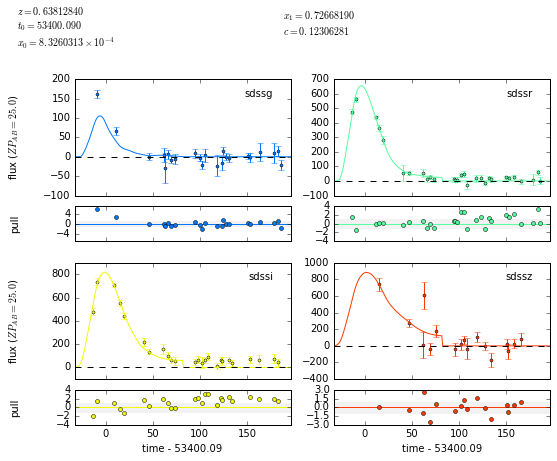

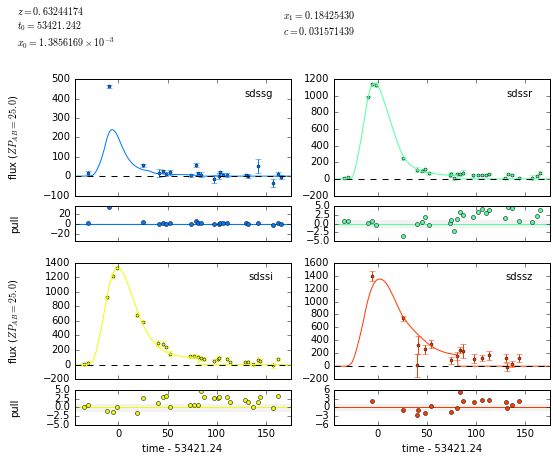

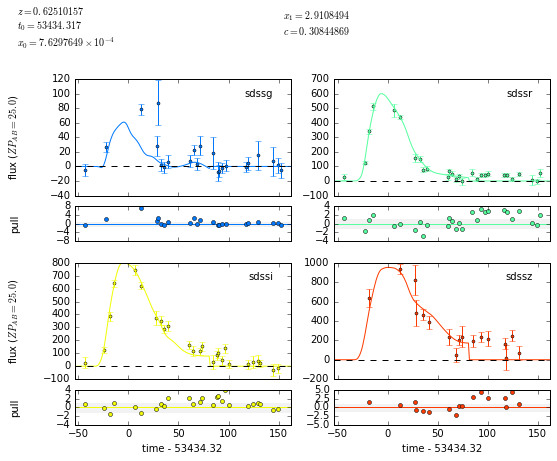

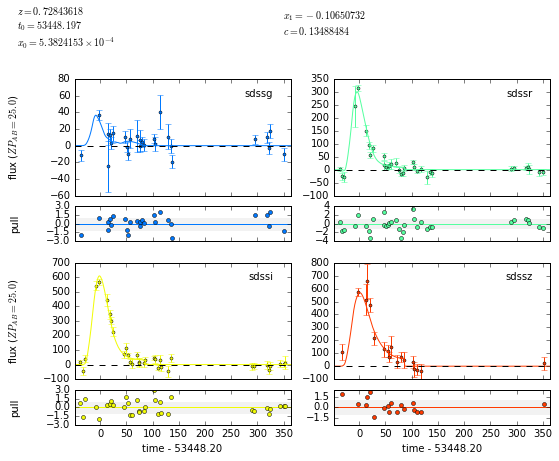

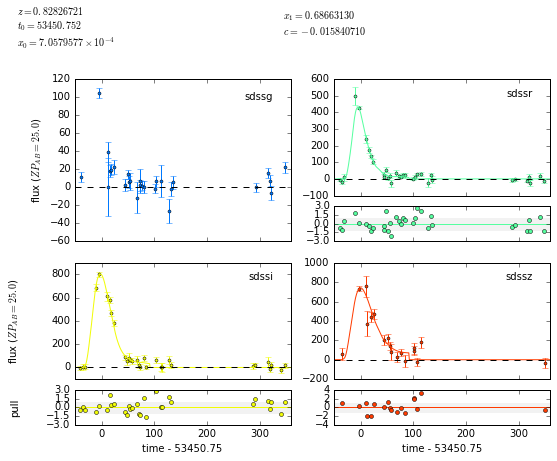

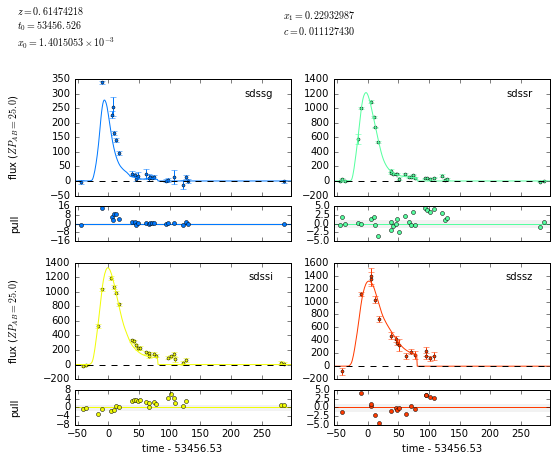

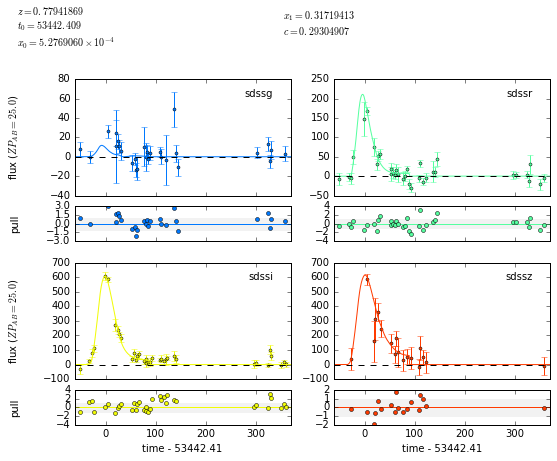

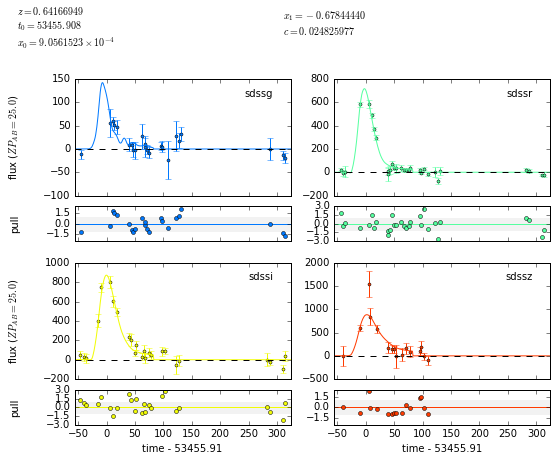

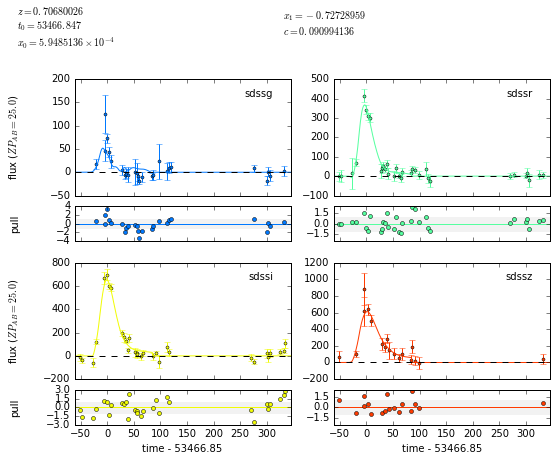

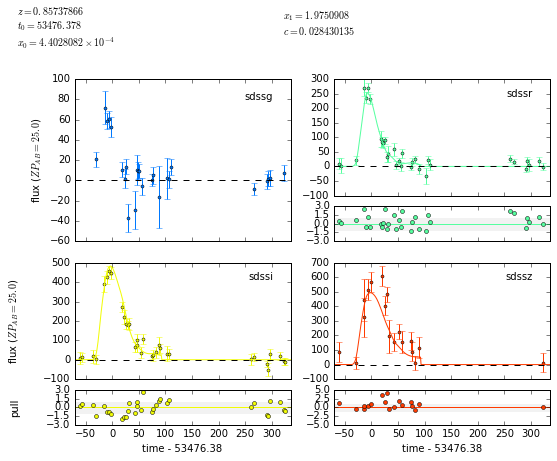

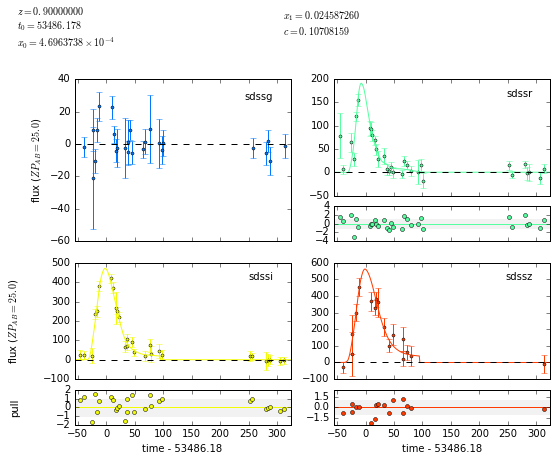

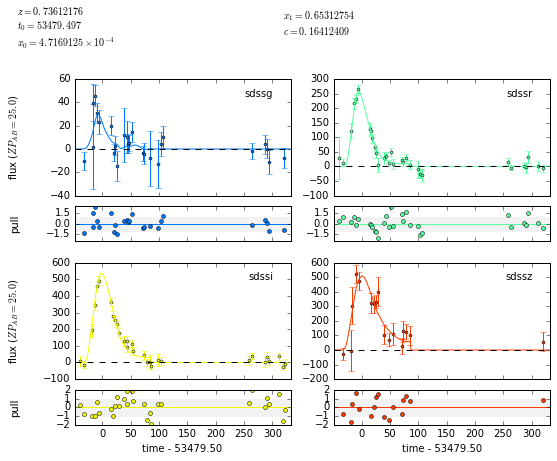

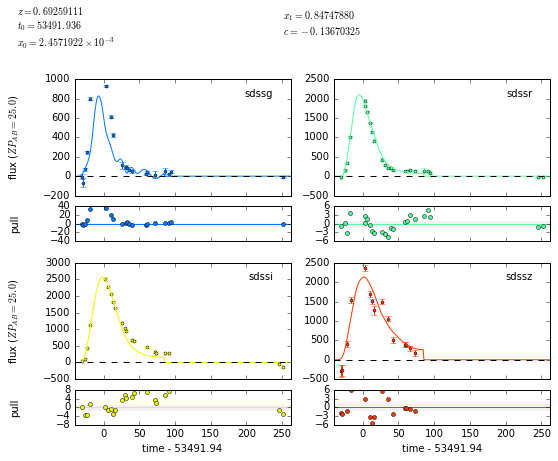

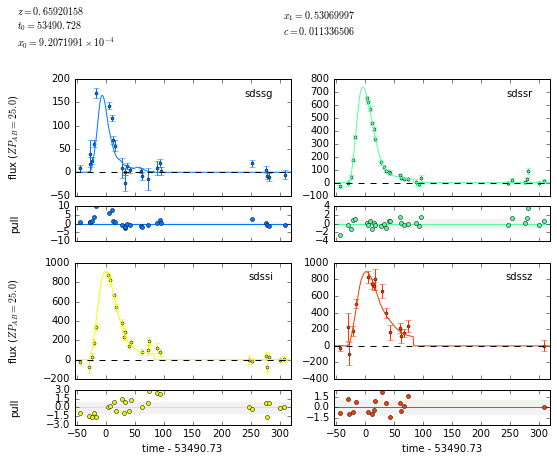

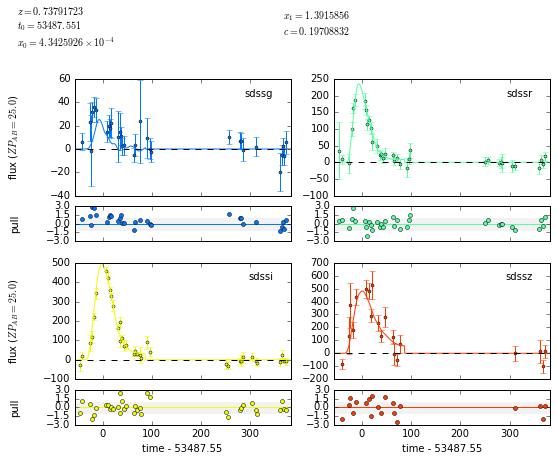

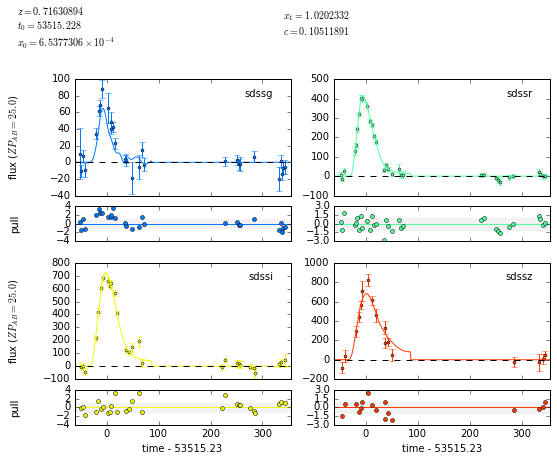

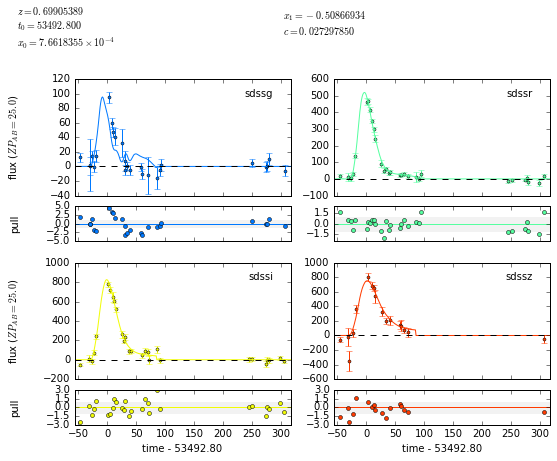

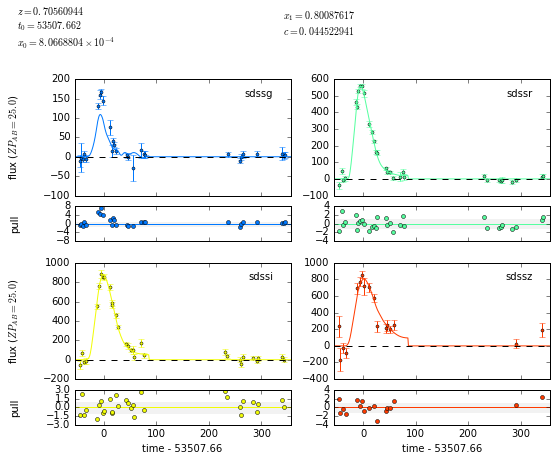

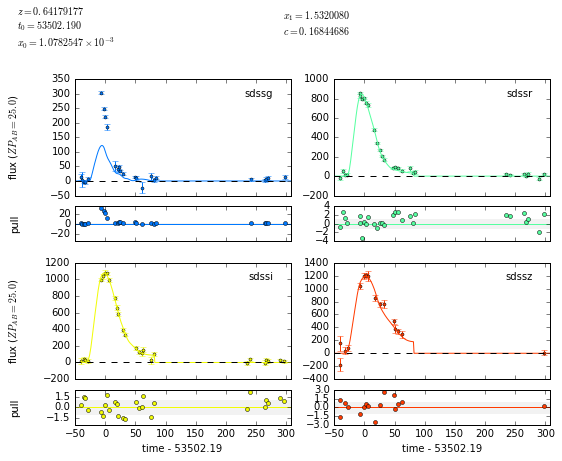

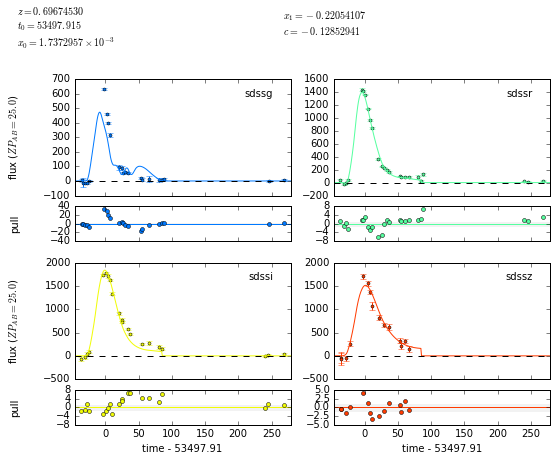

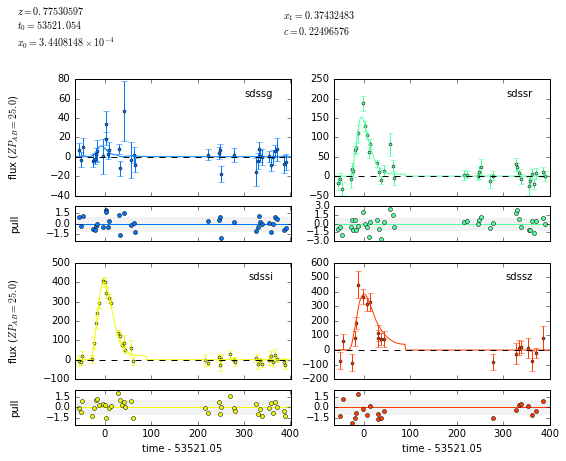

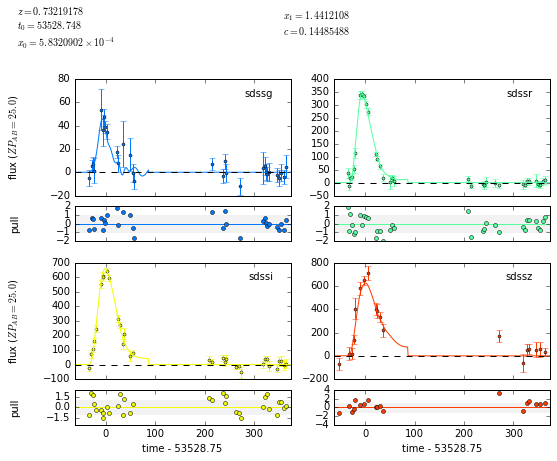

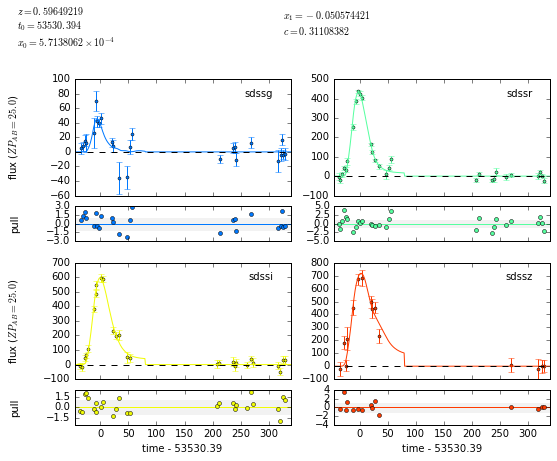

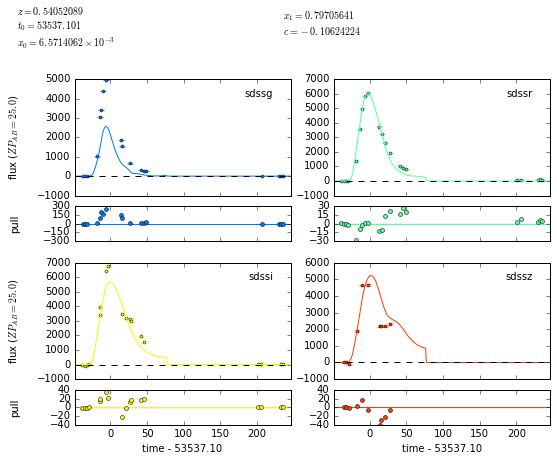

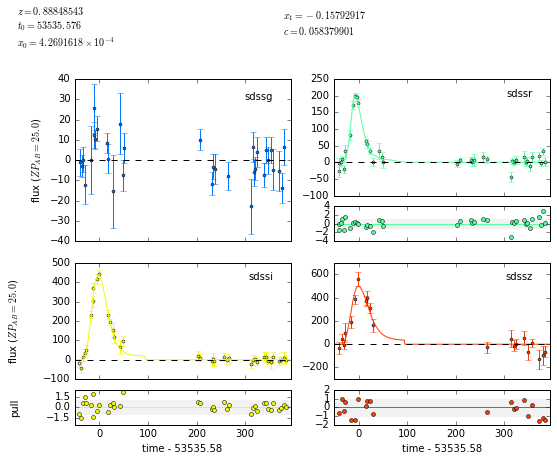

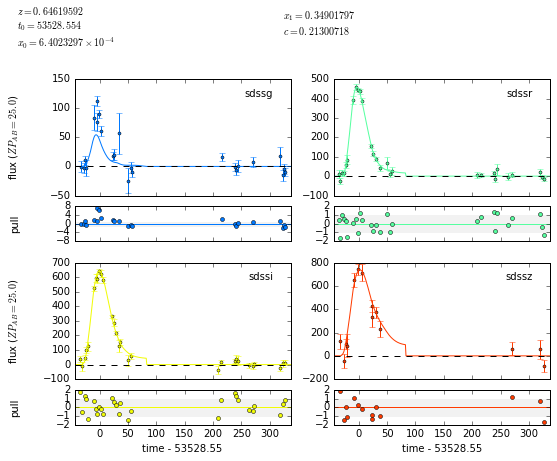

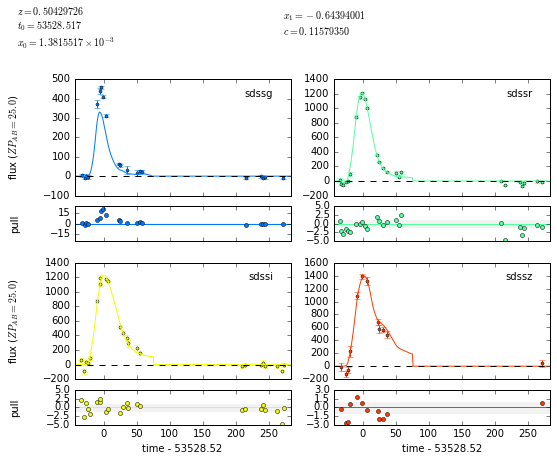

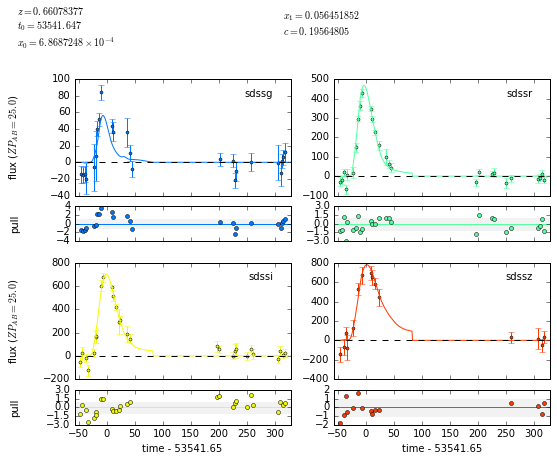

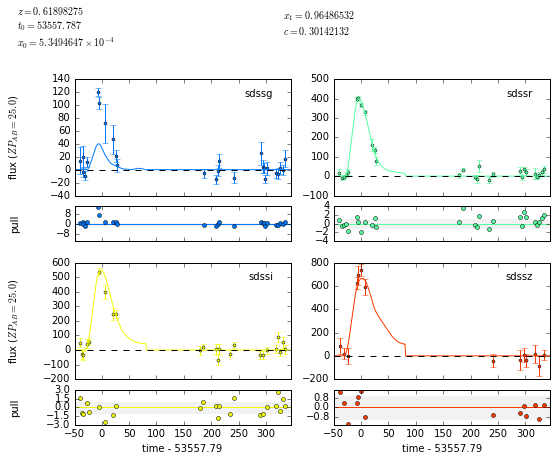

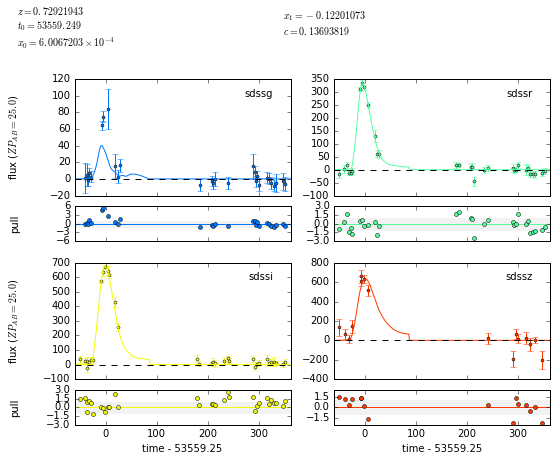

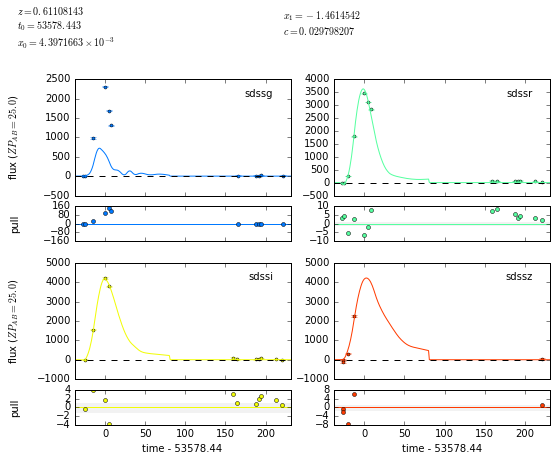

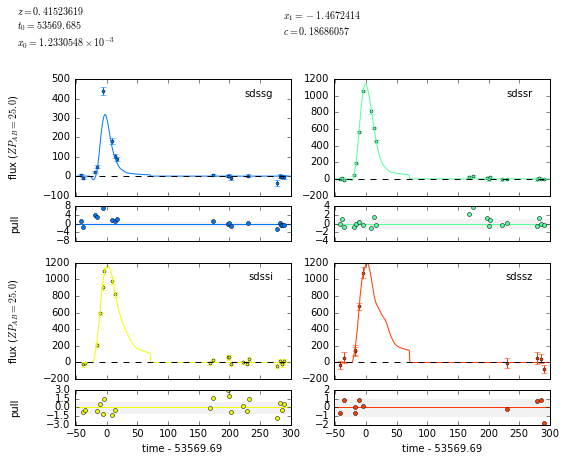

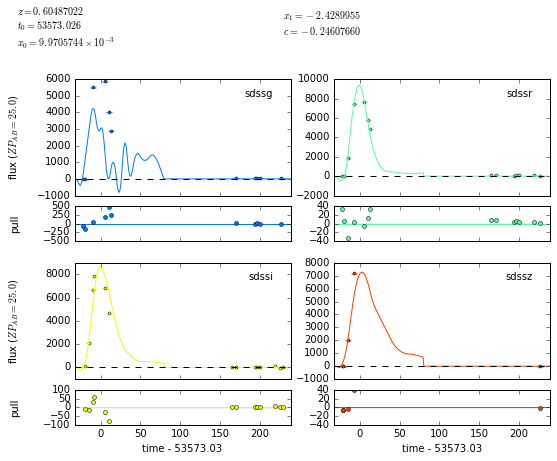

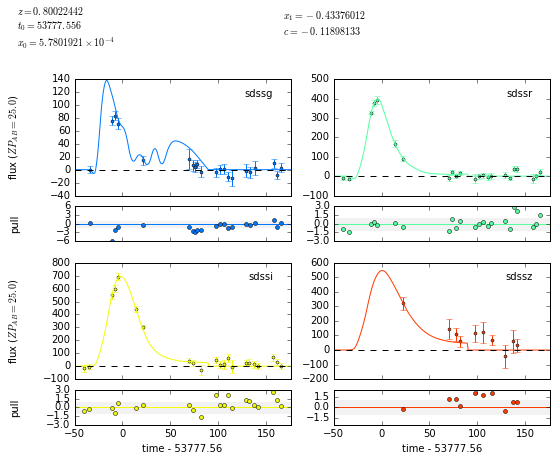

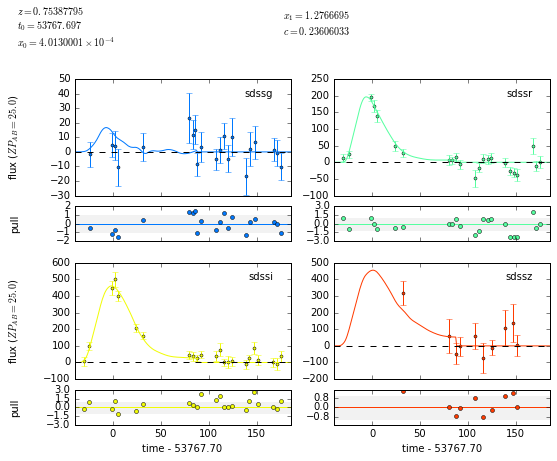

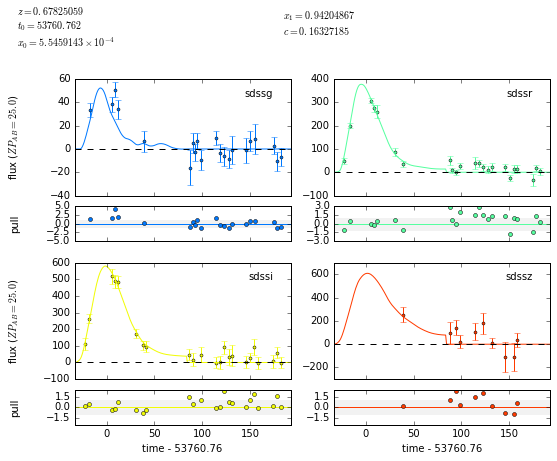

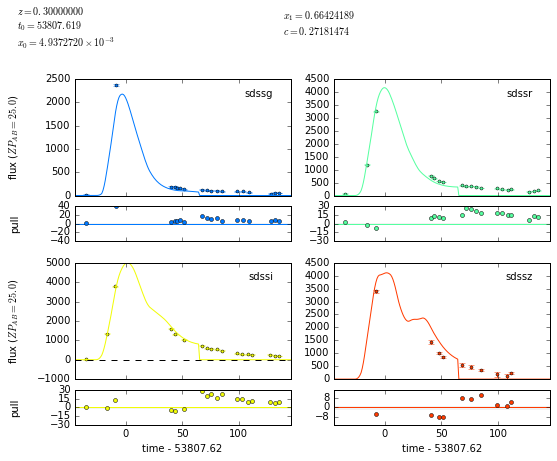

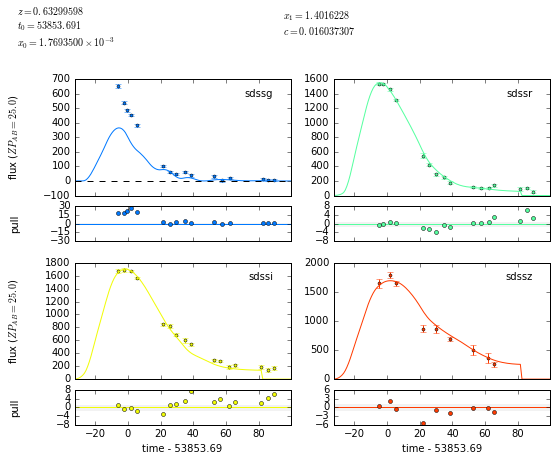

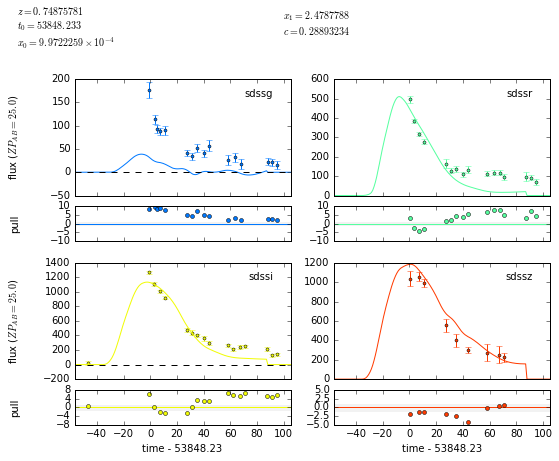

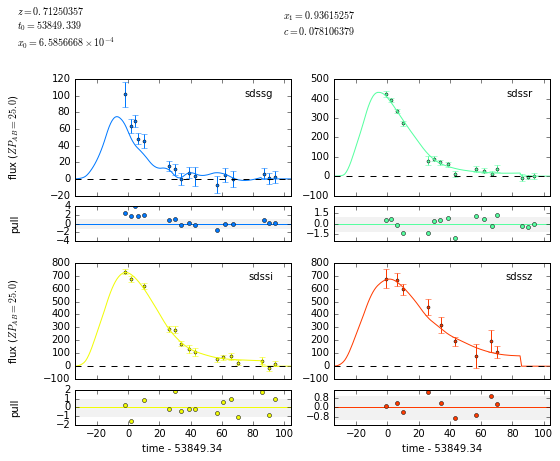

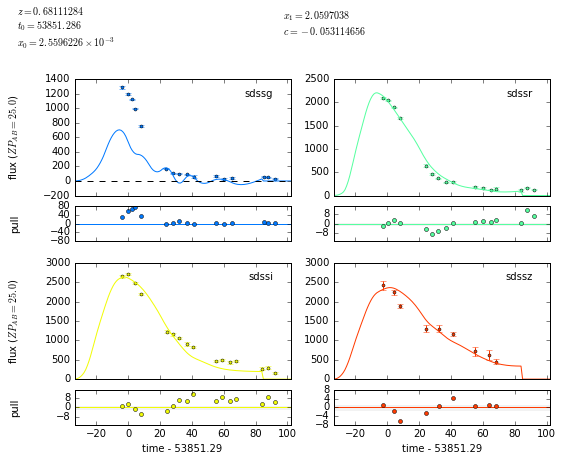

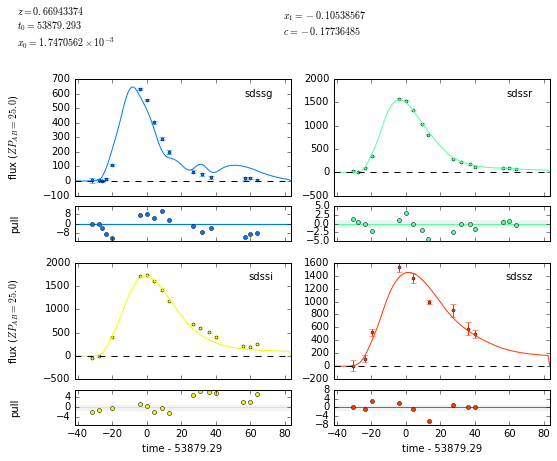

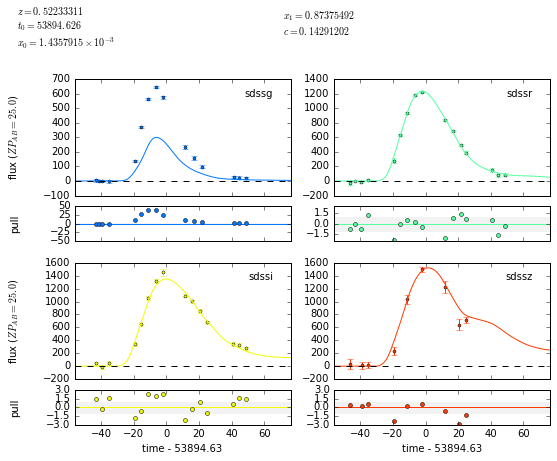

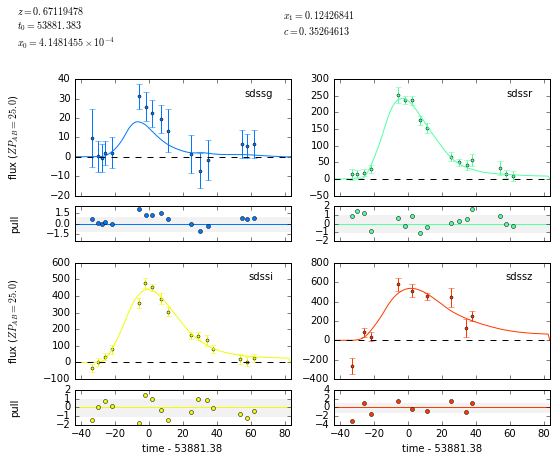

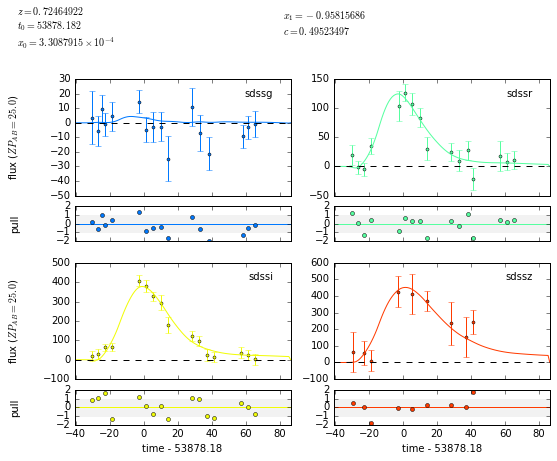

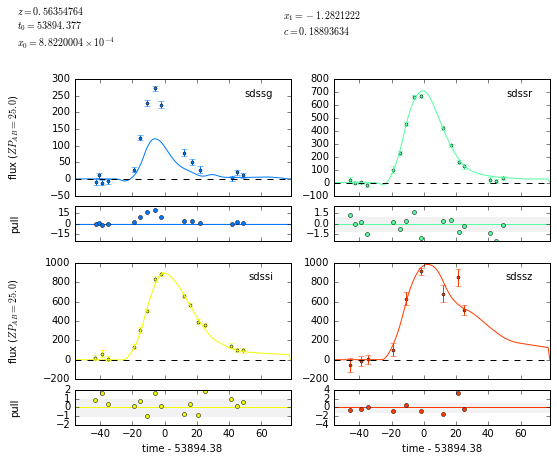

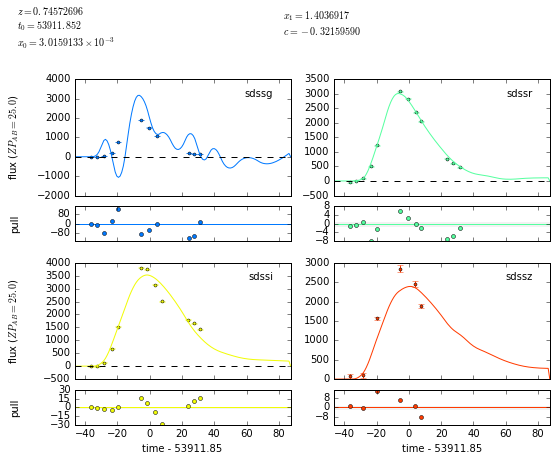

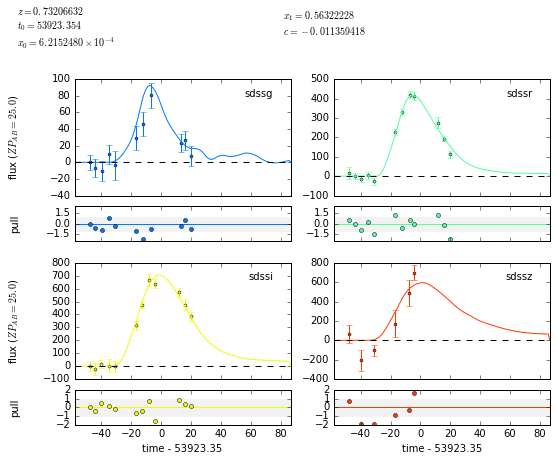

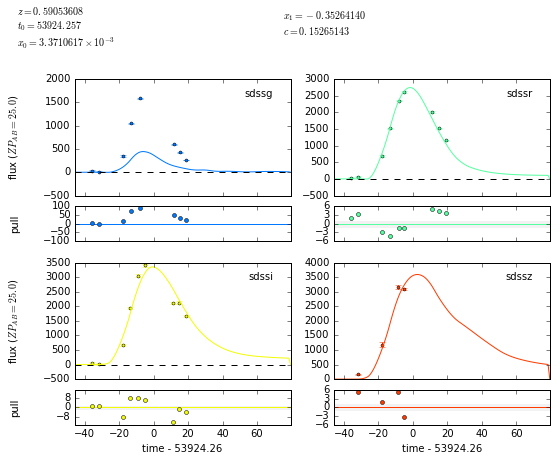

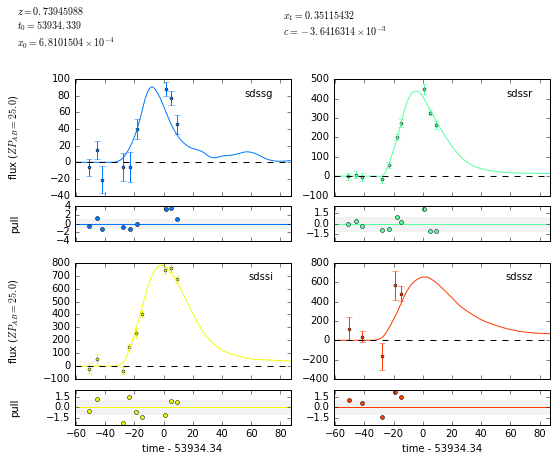

In [11]:
f_models = []
chi_sqrds = []
for s in snls_array:
    data = sncosmo.load_example_data()
    model = sncosmo.Model(source='salt2')
    res, fitted_model = sncosmo.fit_lc(s, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.3, 0.9)})
    sncosmo.plot_lc(s, model=fitted_model)
    plt.show()
    df = res.ndof  # number of degrees of freedom in fit
    chisq = res.chisq
    f_models.append(fitted_model)
    chi_sqrds.append(chisq/df)

Plotting all $\chi^2$ values

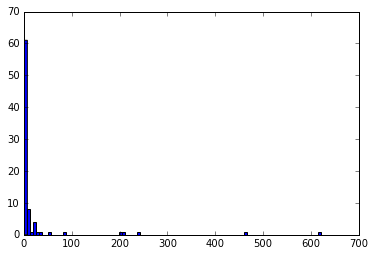

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

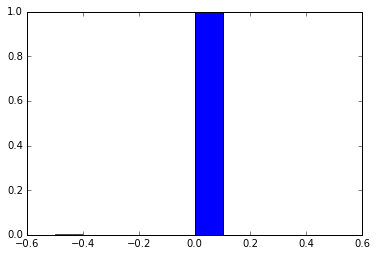

In [12]:
plt.hist(chi_sqrds, bins=100)
plt.show()


chi_sqrds_t = [chi_sqrds<10]
plt.hist(chi_sqrds_t)

(array([ 26.,  19.,   4.,   3.,   3.,   2.,   1.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   2.]),
 array([ 0.89535142,  1.34791392,  1.80047642,  2.25303893,  2.70560143,
         3.15816394,  3.61072644,  4.06328895,  4.51585145,  4.96841395,
         5.42097646,  5.87353896,  6.32610147,  6.77866397,  7.23122648,
         7.68378898,  8.13635148,  8.58891399,  9.04147649,  9.494039  ,
         9.9466015 ]),
 <a list of 20 Patch objects>)

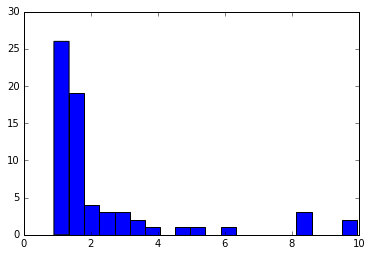

In [14]:
a = np.array(chi_sqrds)
b = a[a < 10]
plt.hist(b, bins=20)

In [15]:
def skewed_gaussian_chi(lc):
    lc_c = []

    mask = lc["bandpass"] == "sdssi"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssg"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssz"
    lc_c.append(lc[mask])

    mask = lc["bandpass"] == "sdssr"
    lc_c.append(lc[mask])
    
    chi_sqrds = []
    dofs = []
    
    for l in lc_c:
        
        if len(l) > 5:
            try:
                opt, pcov, chi, dof = show_fit_mod_gaussians(l, snls_colors, plot=True)
                chi_sqrds.append(chi)
                dofs.append(dof)
            except Exception as e:
                print e
                chi_sqrds.append(10000)
                dofs.append(1)

      
        
    return np.sum(chi_sqrds)  / np.sum(dofs)
    

>>>>>>>>0


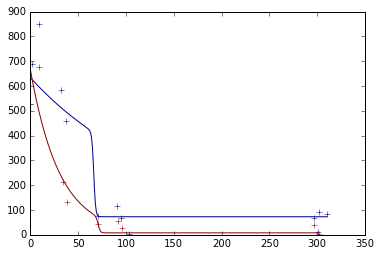

>>>>>>>>1


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in divide


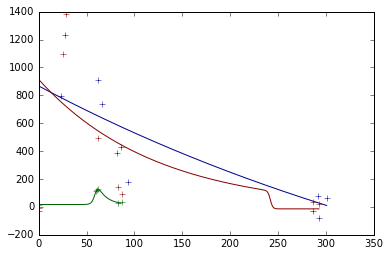

>>>>>>>>2


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


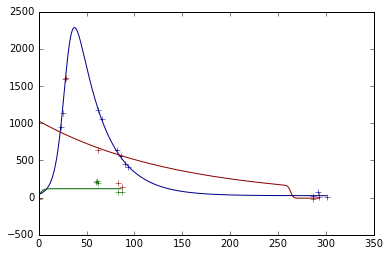

>>>>>>>>3


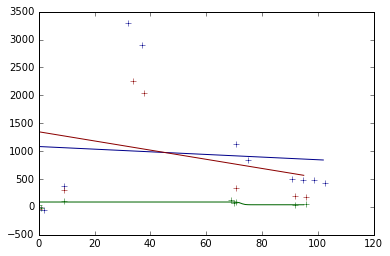

>>>>>>>>4


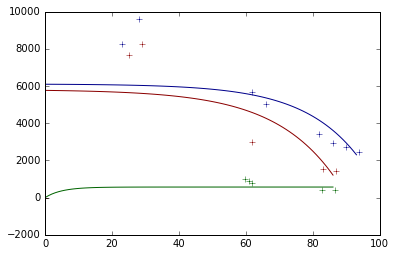

>>>>>>>>5
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


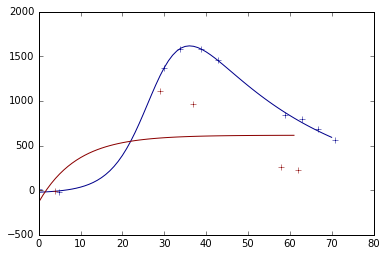

>>>>>>>>6
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


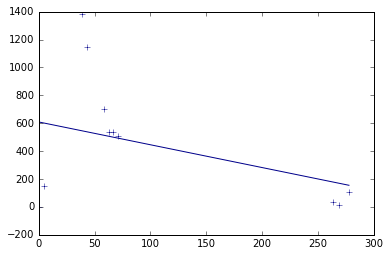

>>>>>>>>7


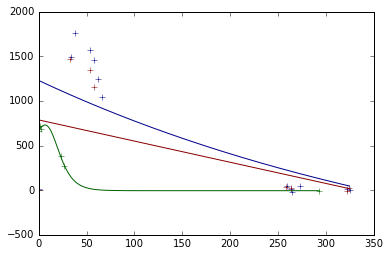

>>>>>>>>8


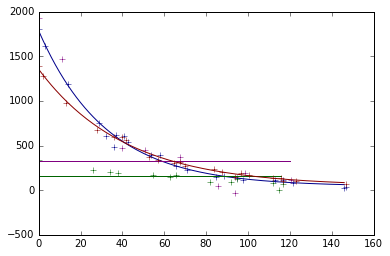

>>>>>>>>9


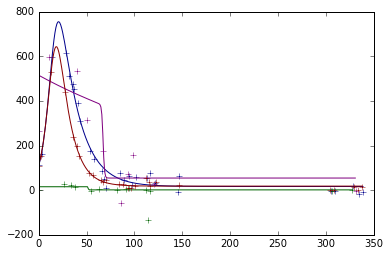

>>>>>>>>10


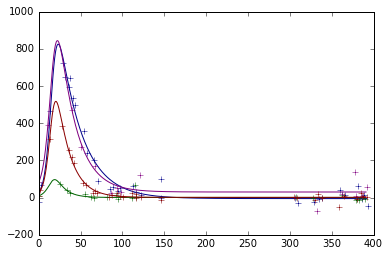

>>>>>>>>11


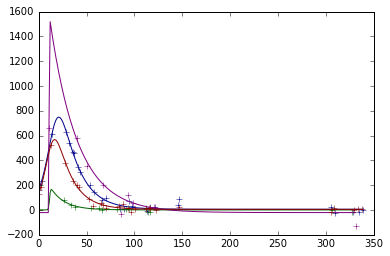

>>>>>>>>12


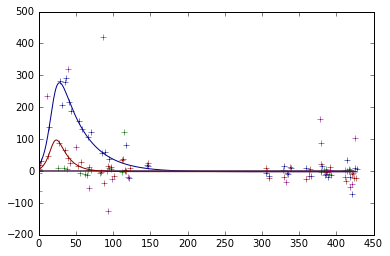

>>>>>>>>13


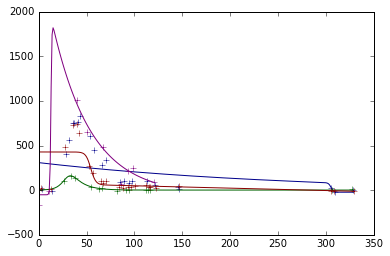

>>>>>>>>14


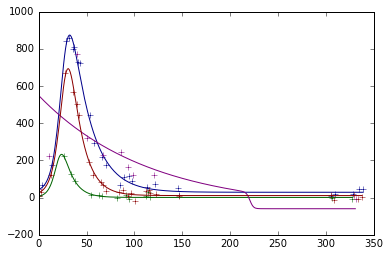

>>>>>>>>15


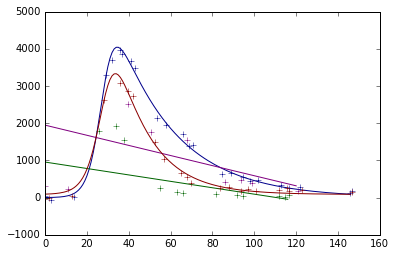

>>>>>>>>16


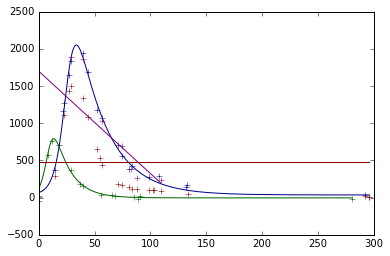

>>>>>>>>17
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


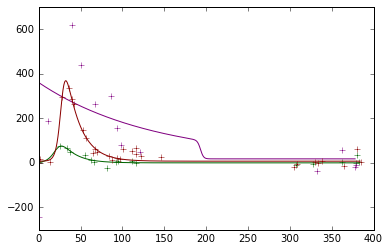

>>>>>>>>18


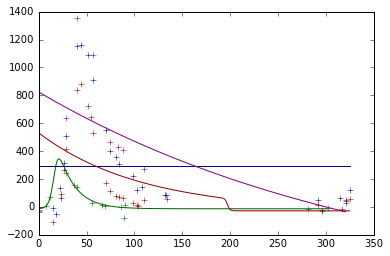

>>>>>>>>19
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


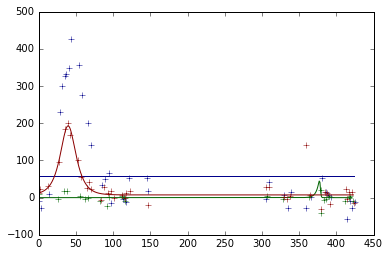

>>>>>>>>20


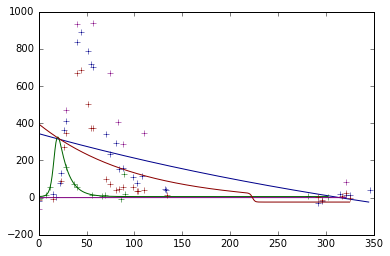

>>>>>>>>21


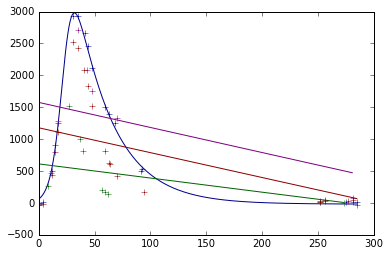

>>>>>>>>22


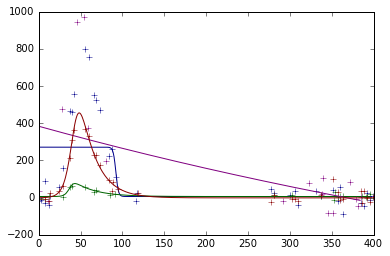

>>>>>>>>23


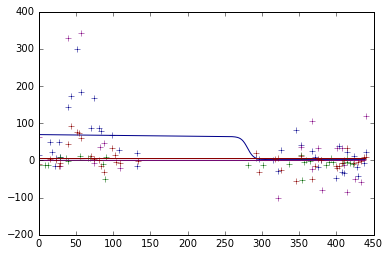

>>>>>>>>24


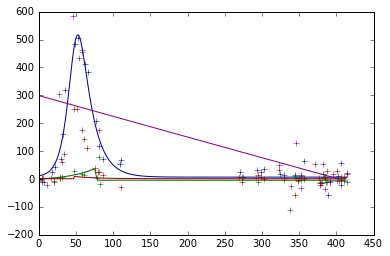

>>>>>>>>25


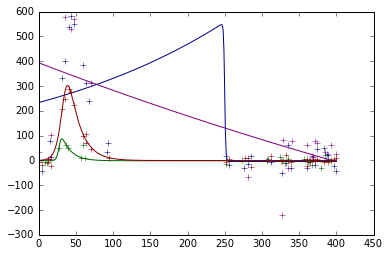

>>>>>>>>26
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


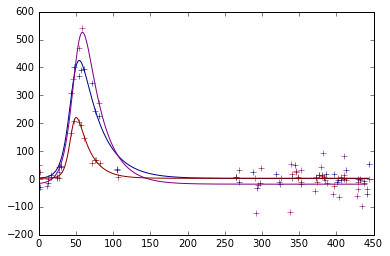

>>>>>>>>27


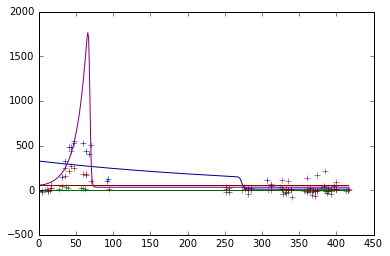

>>>>>>>>28


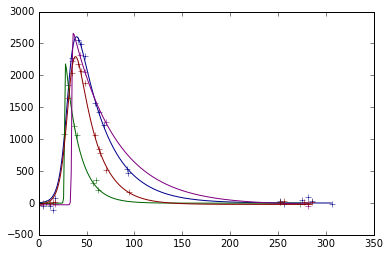

>>>>>>>>29


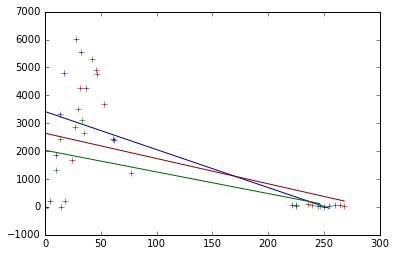

>>>>>>>>30


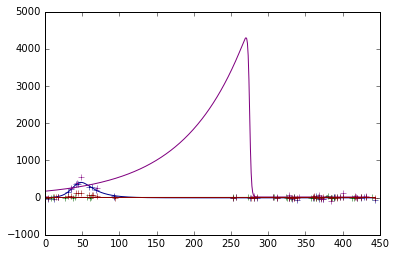

>>>>>>>>31


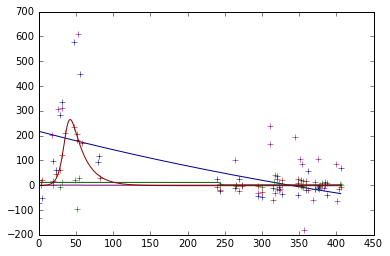

>>>>>>>>32


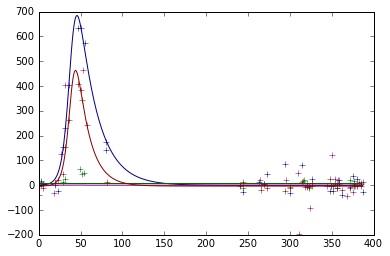

>>>>>>>>33


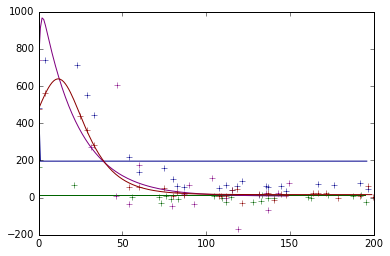

>>>>>>>>34


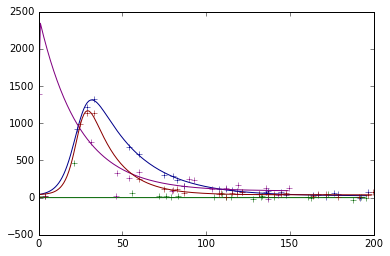

>>>>>>>>35


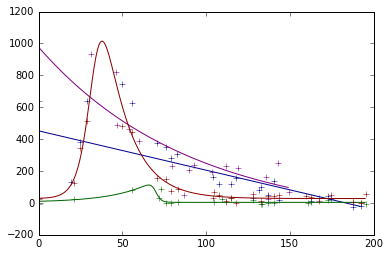

>>>>>>>>36


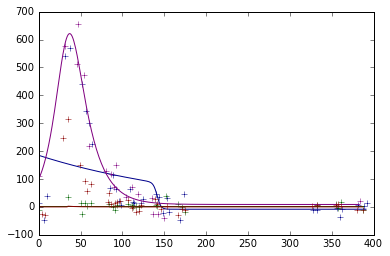

>>>>>>>>37


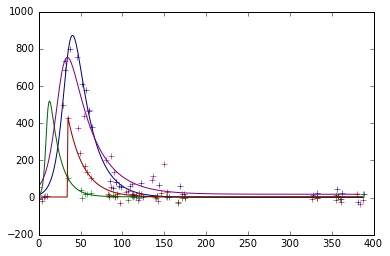

>>>>>>>>38
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


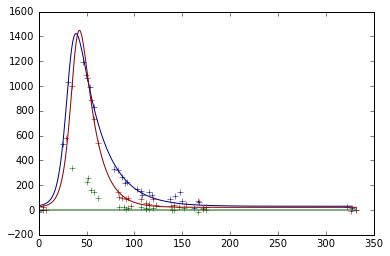

>>>>>>>>39


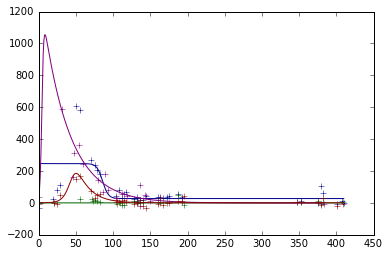

>>>>>>>>40


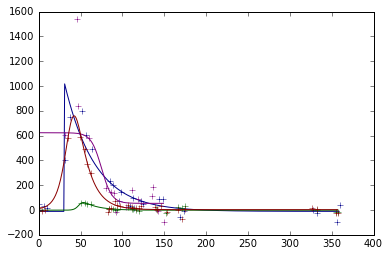

>>>>>>>>41


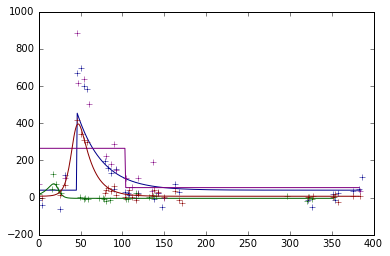

>>>>>>>>42


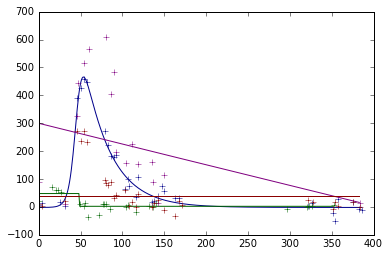

>>>>>>>>43


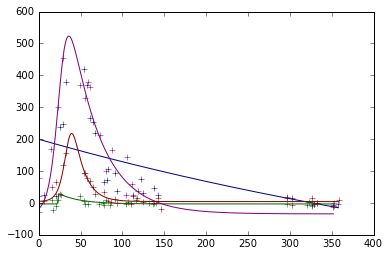

>>>>>>>>44


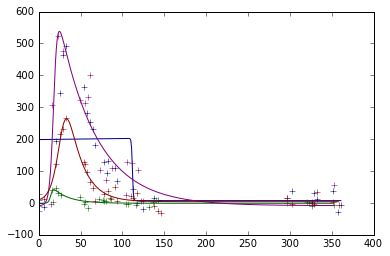

>>>>>>>>45
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


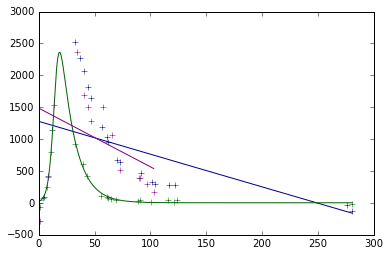

>>>>>>>>46
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


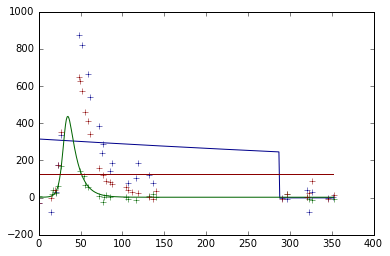

>>>>>>>>47
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


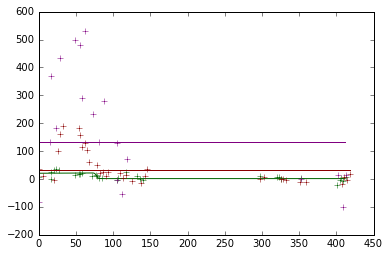

>>>>>>>>48


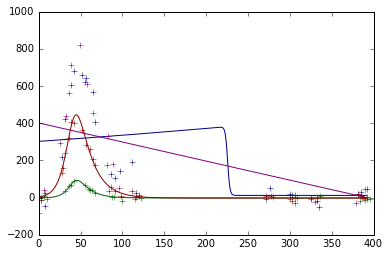

>>>>>>>>49


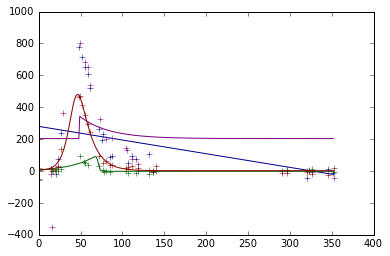

>>>>>>>>50


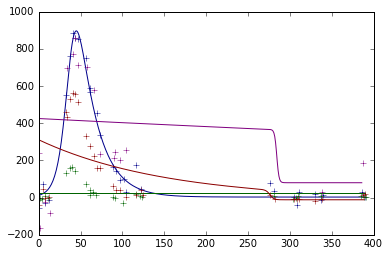

>>>>>>>>51
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


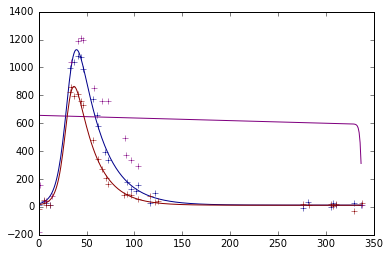

>>>>>>>>52
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


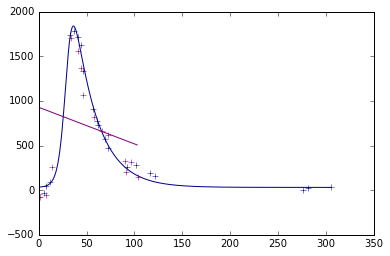

>>>>>>>>53


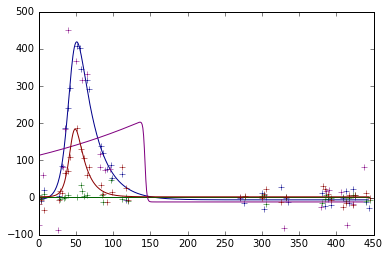

>>>>>>>>54


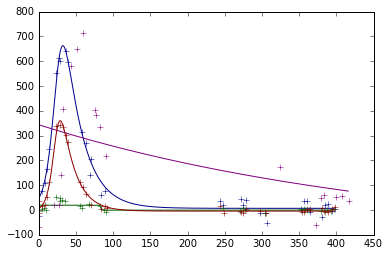

>>>>>>>>55


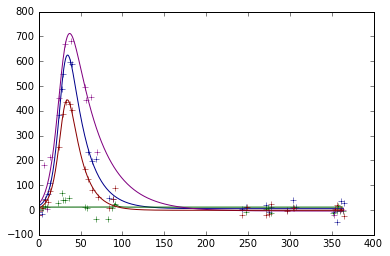

>>>>>>>>56
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


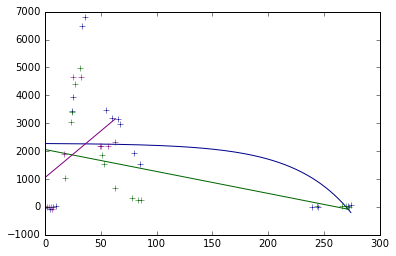

>>>>>>>>57


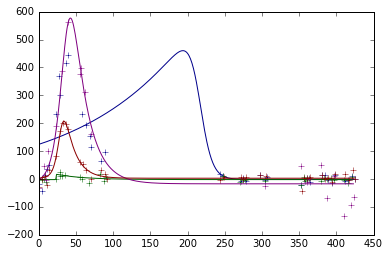

>>>>>>>>58


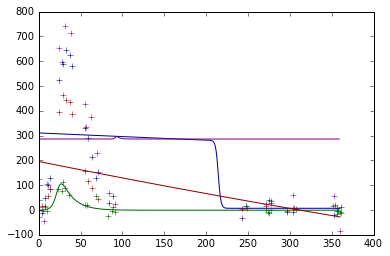

>>>>>>>>59
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


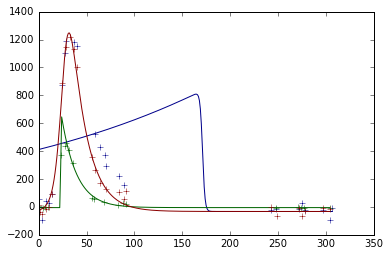

>>>>>>>>60


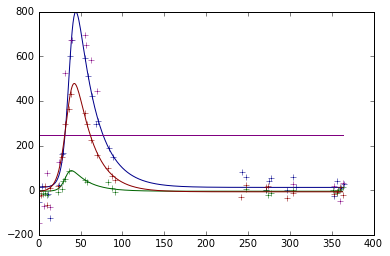

>>>>>>>>61


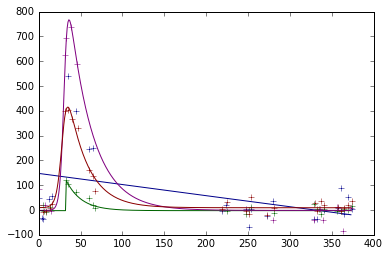

>>>>>>>>62


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in multiply


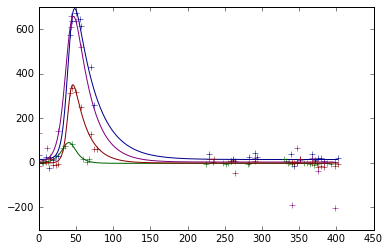

>>>>>>>>63


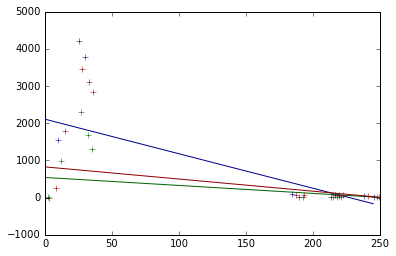

>>>>>>>>64


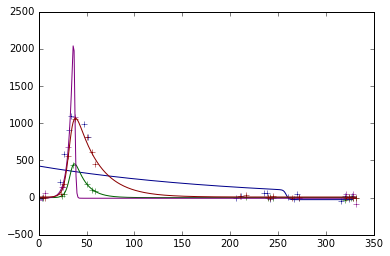

>>>>>>>>65


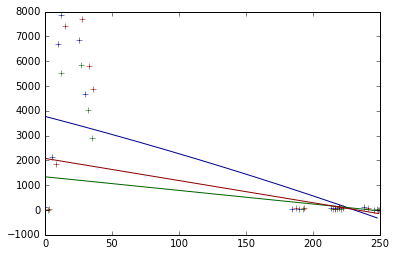

>>>>>>>>66


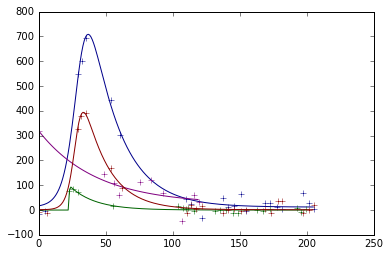

>>>>>>>>67


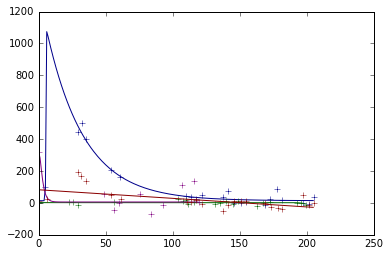

>>>>>>>>68
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


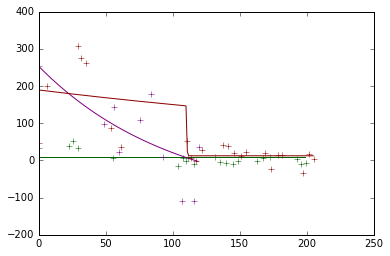

>>>>>>>>69


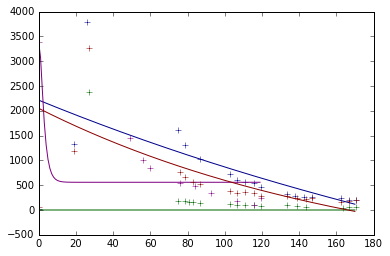

>>>>>>>>70
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


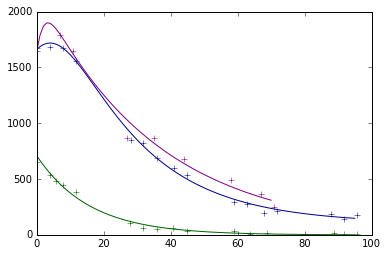

>>>>>>>>71


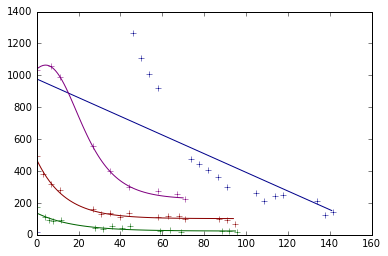

>>>>>>>>72


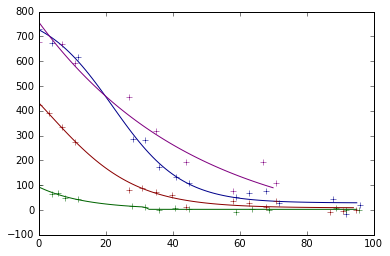

>>>>>>>>73
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


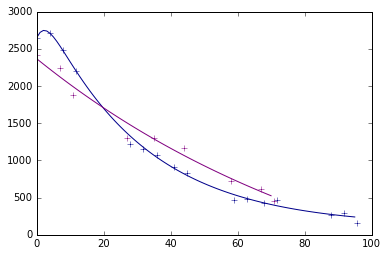

>>>>>>>>74
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


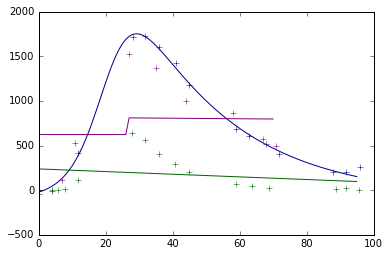

>>>>>>>>75


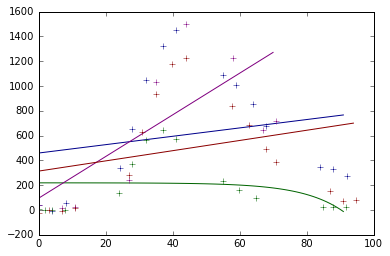

>>>>>>>>76


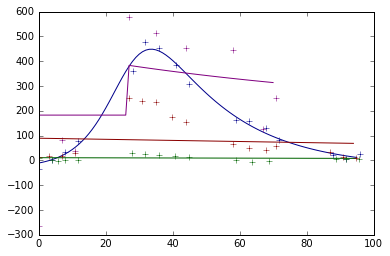

>>>>>>>>77


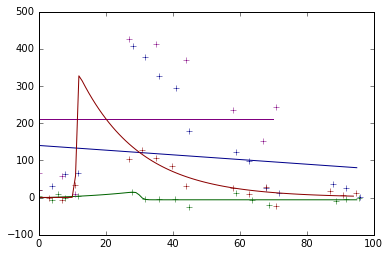

>>>>>>>>78


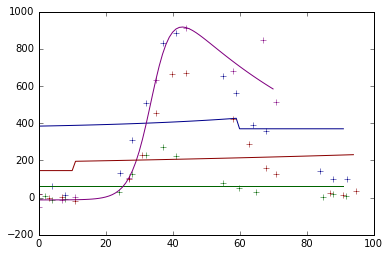

>>>>>>>>79


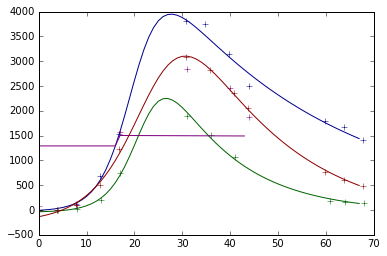

>>>>>>>>80
Optimal parameters not found: Number of calls to function has reached maxfev = 50000.


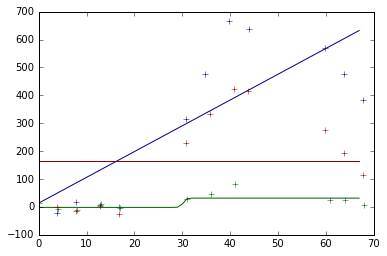

>>>>>>>>81


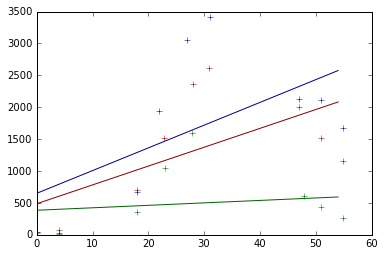

>>>>>>>>82


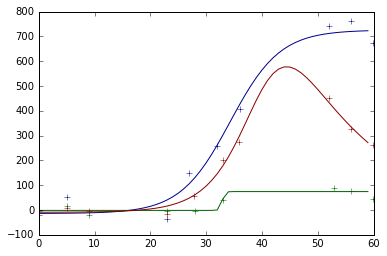

In [16]:
values = []
for i, lc in enumerate(snls_array):
    print ">>>>>>>>"+str(i)
    values.append(skewed_gaussian_chi(lc))
    plt.show()
    

In [17]:
values

[28.785596915387032,
 727.26971136519614,
 609.41397833726694,
 3103.926939463624,
 30496.240566777749,
 1853.8930261683797,
 1808.9089788099584,
 2107.3076630313158,
 18.426958066479155,
 1.0949566144971756,
 1.2801879778590595,
 1.2176391147091161,
 1.6256808955899393,
 159.26256911553651,
 3.0195443320084157,
 578.71343780934842,
 716.48683808866622,
 214.79934222538088,
 187.92746706952752,
 127.49918497619105,
 138.50444675423333,
 2870.5827300134438,
 12.646951436600913,
 3.6811396130888361,
 15.774604320887473,
 11.605677819119753,
 105.21810484685211,
 21.799994409532324,
 10.825757875605635,
 18352.127279480843,
 5.7932150655757919,
 7.2053048976065313,
 4.8429137852224402,
 27.052902020979069,
 57.248925882040531,
 10.278615218806822,
 23.148988047364362,
 2.6466293608942233,
 236.85783522276617,
 10.845471492726062,
 1.951617451664267,
 5.3973392527714266,
 9.7860558266414568,
 6.9682844605636092,
 7.1247353684209926,
 380.10377286552853,
 230.55932971237809,
 148.4459733819

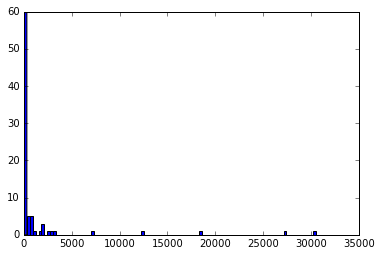

In [18]:
plt.hist(values, bins=100)
plt.show()

26


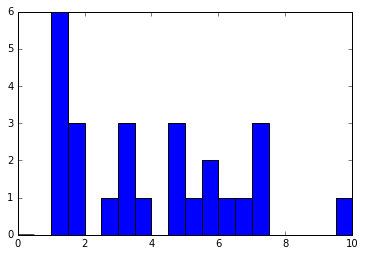

In [26]:
a = np.array(values)
b = a[a < 10]
plt.hist(b, range=(0,10), bins=20)
print(len(b))

In [20]:
for a, b in zip(chi_sqrds, values):
    print a, "----", b

3.75819561815 ---- 28.7855969154
2.90450838936 ---- 727.269711365
11.6054719105 ---- 609.413978337
13.9973550162 ---- 3103.92693946
460.957356248 ---- 30496.2405668
13.0596054966 ---- 1853.89302617
2.72001050158 ---- 1808.90897881
2.07949184351 ---- 2107.30766303
56.3133686264 ---- 18.4269580665
1.44423876986 ---- 1.0949566145
1.19571651316 ---- 1.28018797786
1.04686526799 ---- 1.21763911471
1.50498591855 ---- 1.62568089559
4.86689932087 ---- 159.262569116
2.32155630599 ---- 3.01954433201
23.4999690988 ---- 578.713437809
9.94660150163 ---- 716.486838089
1.13673634077 ---- 214.799342225
3.53121728597 ---- 187.92746707
1.3164241576 ---- 127.499184976
2.51387402691 ---- 138.504446754
20.9037936126 ---- 2870.58273001
1.37336768391 ---- 12.6469514366
1.30691726288 ---- 3.68113961309
1.40317604149 ---- 15.7746043209
1.14824888012 ---- 11.6056778191
1.03618911294 ---- 105.218104847
1.20717463354 ---- 21.7999944095
9.55826605593 ---- 10.8257578756
210.414398447 ---- 18352.1272795
1.00733956128

In [21]:
len(matches)

NameError: name 'matches' is not defined